# Neural Networks

In this tutorial we learn how the most basic neural networks work.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

# Training a neural network

## Generate data
Create toy dataset, define class for weights intialization etc.

In [2]:
# set the true weights, use them for data generation later:
w_1 = np.array(np.transpose([[2, 1], [1, 0], [1, -1]]))
b_1 = np.array(np.expand_dims([1, 0, 2], axis=0))
w_2 = np.array([[1,], [1,], [-2,]])
b_2 = 1

w_1.shape, b_1.shape, w_2.shape

# Print the ouput nicely
print("WEIGHTS OF THE MODEL \n")
print("Hidden layer weights: \n{} \n".format(w_1))
print("Hidden layer bias: \n{} \n".format(b_1))
print("Output layer weights: \n{} \n".format(w_2))
print("Output layer bias: \n{} \n".format(b_2))

WEIGHTS OF THE MODEL 

Hidden layer weights: 
[[ 2  1  1]
 [ 1  0 -1]] 

Hidden layer bias: 
[[1 0 2]] 

Output layer weights: 
[[ 1]
 [ 1]
 [-2]] 

Output layer bias: 
1 



In [3]:
# define class for initialization of weights - fix seed to use the same numbers always
class MyInit(tf.keras.initializers.Initializer):

  def __init__(self, mean, std):
    self.mean = mean
    self.std = std

    
  def __call__(self, shape, dtype=None, **kwargs):
    tf.random.set_seed(11)
    return tf.cast(tf.cast(tf.random.normal(
        shape, mean=self.mean, stddev=self.std, dtype=dtype), tf.int32), tf.float32)

  def get_config(self):  # To support serialization
    return {"mean": self.mean, "std": self.std}

In [4]:
# define forward propagation
def forward_propagation(x, w_1, b_1, w_2, b_2):
    h = np.matmul(x, w_1) + b_1
    h_relu = np.where(h < 0, 0, h)
    y = np.matmul(h_relu, w_2) + b_2 # output layer
    
    return {'hidden': h, 'hidden_relu': h_relu, 'prediction': y}

In [5]:
# generate training data using the true weights
np.random.seed(seed=73)
x_1 = [-4] + [int(x) for x in np.random.uniform(-2, 4, 100)]
x_2 = [1] + [int(x) for x in np.random.uniform(-2, 4, 100)]
x = np.transpose(np.array([x_1, x_2])) # xka jsou data, y outputy. Tento set pak budeme používat k trenovani site

y = forward_propagation(x, w_1, b_1, w_2, b_2)['prediction']

In [6]:
# convert training data to tf.data.Dataset with batch size
batch_size = 1
train_dataset = tf.data.Dataset.from_tensor_slices((x, y)).batch(batch_size)

## Initialize model

In [7]:
# create a simple NN with the pre-defined intialization:
inputs = tf.keras.Input(shape=(2,), name="input_values")

x1 = tf.keras.layers.Dense(3,
                           activation="relu",
                           name="hidden",
                           kernel_initializer=MyInit(1, 1),
                           bias_initializer=MyInit(2, 1))(inputs)

outputs = tf.keras.layers.Dense(1,
                                name="predictions",
                                kernel_initializer=MyInit(1, 3),
                                bias_initializer=MyInit(2, 0))(x1)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# set the loss and the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01) # SGD je nejjednodussi optimizer (optimizer urcuje jakym zpusobem se posune po tech gradientech, SDG je proste posun v tom smeru maximalni derivaace - to je nejjednodussi, ale muze trvat hrozne dlouho)
loss_fn = tf.keras.losses.MSE # Pak je treba SGD with momentum ktery tomu predchazi tak, ze od toho gradientu odecte jeste alpha*ten predchozi, aby predesel ty periodicite
# tady je to krasne ilustrovany: https://distill.pub/2017/momentum/

In [8]:
# Look at the initialized weights
w1 = model.layers[1].weights[0].numpy()
b1 = model.layers[1].weights[1].numpy()

w2 = model.layers[2].weights[0].numpy()
b2 = model.layers[2].weights[1].numpy()

# Print the ouput nicely
print("WEIGHTS OF THE MODEL \n")
print("Hidden layer weights: \n{} \n".format(w1))
print("Hidden layer bias: \n{} \n".format(b1))
print("Output layer weights: \n{} \n".format(w2))
print("Hidden layer bias: \n{} \n".format(b2))

WEIGHTS OF THE MODEL 

Hidden layer weights: 
[[0. 1. 0.]
 [2. 1. 1.]] 

Hidden layer bias: 
[0. 2. 1.] 

Output layer weights: 
[[-3.]
 [ 3.]
 [ 0.]] 

Hidden layer bias: 
[2.] 



In [9]:
# check the forward propagation
fp = forward_propagation(x[0:1], w1, b1, w2, b2)

# Print the ouput nicely
print("PROPAGATED VALUES \n")
print("Input vector \n{} \n".format(x[0]))
print("Hidden layer before activation \n{} \n".format(fp["hidden"]))
print("Hidden layer after relu \n{} \n".format(fp["hidden_relu"]))
print("Prediction of output layer \n{} \n".format(fp["prediction"]))

PROPAGATED VALUES 

Input vector 
[-4  1] 

Hidden layer before activation 
[[ 2. -1.  2.]] 

Hidden layer after relu 
[[2. 0. 2.]] 

Prediction of output layer 
[[-4.]] 



In [10]:
# take the first batch
for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
    break

x_batch_train.numpy(), y_batch_train.numpy()

(array([[-4,  1]]), array([[1]]))

In [11]:
# Calculate the gradients on the batch:
with tf.GradientTape() as tape:
    prediction = model(x_batch_train, training=True)
    loss_value = loss_fn(y_batch_train, prediction)
# "context manager", potom co se to dokonce se ten tape ulozi asi, podobne jako otvirani csv dokumentu v pythonu

grads = tape.gradient(loss_value, model.trainable_weights) #derivace loss podle tech trainable vah

# Print the output nicely
print("Prediction:{}, Target:{}, Loss:{}".format(prediction, y[0], loss_value))
print("\n>>> GRADIENTS:")
print("Hidden layer weights \n{} \n".format(grads[0].numpy())) # to jsou ty gradienty, ne ty nove vahy
print("Hidden layer bias \n{} \n".format(grads[1].numpy()))
print("Output layer weights \n{} \n".format(grads[2].numpy()))
print("Output layer bias \n{} \n".format(grads[3].numpy()))

Prediction:[[-4.]], Target:[1], Loss:[25.]

>>> GRADIENTS:
Hidden layer weights 
[[-120.    0.    0.]
 [  30.   -0.   -0.]] 

Hidden layer bias 
[30. -0. -0.] 

Output layer weights 
[[-20.]
 [ -0.]
 [-20.]] 

Output layer bias 
[-10.] 



In [12]:
# apply one SGD update
optimizer.apply_gradients(zip(grads, model.trainable_weights))

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

In [13]:
# check the weights after the update:
w1 = model.layers[1].weights[0].numpy()
b1 = model.layers[1].weights[1].numpy()

w2 = model.layers[2].weights[0].numpy()
b2 = model.layers[2].weights[1].numpy()

# Print the ouput nicely
print("UPDATED WEIGHTS OF THE MODEL \n")
print("Hidden layer weights: \n{} \n".format(w1))
print("Hidden layer bias: \n{} \n".format(b1))
print("Output layer weights: \n{} \n".format(w2))
print("Hidden layer bias: \n{} \n".format(b2))


UPDATED WEIGHTS OF THE MODEL 

Hidden layer weights: 
[[1.1999999 1.        0.       ]
 [1.7       1.        1.       ]] 

Hidden layer bias: 
[-0.29999998  2.          1.        ] 

Output layer weights: 
[[-2.8       ]
 [ 3.        ]
 [ 0.19999999]] 

Hidden layer bias: 
[2.1] 



In [14]:
# check the prediction
prediction = model(x_batch_train, training=True)
loss_value = loss_fn(y_batch_train, prediction)

print("Prediction:{}, Target:{}, Loss:{}".format(prediction, y[0], loss_value))

Prediction:[[2.5]], Target:[1], Loss:[2.25]


### Run the training loop

In [15]:
epochs = 16
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:

            pred = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, pred)

        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        mse = np.mean((model(x).numpy() - y)**2)
        
    print('>>> Loss {:.3f}'.format(mse))


Start of epoch 0
>>> Loss 0.720

Start of epoch 1
>>> Loss 0.361

Start of epoch 2
>>> Loss 0.311

Start of epoch 3
>>> Loss 0.272

Start of epoch 4
>>> Loss 0.225

Start of epoch 5
>>> Loss 0.213

Start of epoch 6
>>> Loss 0.156

Start of epoch 7
>>> Loss 0.113

Start of epoch 8
>>> Loss 0.086

Start of epoch 9
>>> Loss 0.045

Start of epoch 10
>>> Loss 0.035

Start of epoch 11
>>> Loss 0.036

Start of epoch 12
>>> Loss 0.047

Start of epoch 13
>>> Loss 0.049

Start of epoch 14
>>> Loss 0.049

Start of epoch 15
>>> Loss 0.017


In [16]:
w1 = model.layers[1].weights[0].numpy()
b1 = model.layers[1].weights[1].numpy()

w2 = model.layers[2].weights[0].numpy()
b2 = model.layers[2].weights[1].numpy()

print("Hidden layer weights: \n{} \n".format(w1))
print("Hidden layer bias: \n{} \n".format(b1))
print("Output layer weights: \n{} \n".format(w2))
print("Hidden layer bias: \n{} \n".format(b2))

Hidden layer weights: 
[[ 0.8380496   1.8128631  -0.25347403]
 [-0.95671076  0.66604346  0.6694228 ]] 

Hidden layer bias: 
[1.8954308  0.5246789  0.66958815] 

Output layer weights: 
[[-1.9003438 ]
 [ 1.4643725 ]
 [ 0.35568428]] 

Hidden layer bias: 
[0.5498195] 



In [17]:
np.mean((model(x).numpy() - y)**2)

0.01748506044185453

### Playing with optimizer and learning rates

http://2.bp.blogspot.com/-q6l20Vs4P_w/VPmIC7sEhnI/AAAAAAAACC4/g3UOUX2r_yA/s400/

In [18]:
batch_size = 10
train_dataset = tf.data.Dataset.from_tensor_slices((x, y)).batch(batch_size)

In [19]:
inputs = tf.keras.Input(shape=(2,), name="input_values")

x1 = tf.keras.layers.Dense(3,
                           activation="relu",
                           name="hidden",
                           kernel_initializer=MyInit(1, 1),
                           bias_initializer=MyInit(2, 1))(inputs)

outputs = tf.keras.layers.Dense(1,
                                name="predictions",
                                kernel_initializer=MyInit(1, 3),
                                bias_initializer=MyInit(2, 0))(x1)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.MSE

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

epochs = 128
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:

            pred = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, pred)

        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        mse = np.mean((model(x).numpy() - y)**2)
        
    print('>>> Loss {:.4f}'.format(mse))


Start of epoch 0
>>> Loss 10.0086

Start of epoch 1
>>> Loss 6.3836

Start of epoch 2
>>> Loss 4.1899

Start of epoch 3
>>> Loss 2.4007

Start of epoch 4
>>> Loss 1.8415

Start of epoch 5
>>> Loss 1.3954

Start of epoch 6
>>> Loss 1.1239

Start of epoch 7
>>> Loss 0.9543

Start of epoch 8
>>> Loss 0.8465

Start of epoch 9
>>> Loss 0.7631

Start of epoch 10
>>> Loss 0.6984

Start of epoch 11
>>> Loss 0.6488

Start of epoch 12
>>> Loss 0.6150

Start of epoch 13
>>> Loss 0.5858

Start of epoch 14
>>> Loss 0.5604

Start of epoch 15
>>> Loss 0.5381

Start of epoch 16
>>> Loss 0.5183

Start of epoch 17
>>> Loss 0.5006

Start of epoch 18
>>> Loss 0.4847

Start of epoch 19
>>> Loss 0.4703

Start of epoch 20
>>> Loss 0.4572

Start of epoch 21
>>> Loss 0.4452

Start of epoch 22
>>> Loss 0.4343

Start of epoch 23
>>> Loss 0.4242

Start of epoch 24
>>> Loss 0.4150

Start of epoch 25
>>> Loss 0.4065

Start of epoch 26
>>> Loss 0.3987

Start of epoch 27
>>> Loss 0.3915

Start of epoch 28
>>> Loss 0

In [21]:
w1 = model.layers[1].weights[0].numpy()
b1 = model.layers[1].weights[1].numpy()

w2 = model.layers[2].weights[0].numpy()
b2 = model.layers[2].weights[1].numpy()

print("Hidden layer weights: \n{} \n".format(w1))
print("Hidden layer bias: \n{} \n".format(b1))
print("Output layer weights: \n{} \n".format(w2))
print("Hidden layer bias: \n{} \n".format(b2))

Hidden layer weights: 
[[ 0.68049085  1.3424367   0.07904254]
 [-0.7097411   0.48730248  0.70848805]] 

Hidden layer bias: 
[1.459946   0.46044096 1.1783974 ] 

Output layer weights: 
[[-2.6617305 ]
 [ 2.0708392 ]
 [ 0.14849414]] 

Hidden layer bias: 
[0.79768693] 



<span style="color:red">**TO DO:** Try different optimizers with different lerning rate, how does the convergence look? Does it converge? How fast? Which one is the best?</span>

## Vanishing gradient

In [22]:
# create a simple NN with the pre-defined intialization:
init = tf.keras.initializers.RandomUniform(minval=0, maxval=1)

inputs = tf.keras.Input(shape=2, name="input_values")

h = tf.keras.layers.Dense(3, activation="tanh")(inputs)
h = tf.keras.layers.Dense(3, activation="tanh", kernel_initializer=init)(h)
h = tf.keras.layers.Dense(3, activation="tanh", kernel_initializer=init)(h)
h = tf.keras.layers.Dense(3, activation="tanh", kernel_initializer=init)(h)
h = tf.keras.layers.Dense(3, activation="tanh", kernel_initializer=init)(h)
h = tf.keras.layers.Dense(3, activation="tanh", kernel_initializer=init)(h)
h = tf.keras.layers.Dense(3, activation="tanh", kernel_initializer=init)(h)
h = tf.keras.layers.Dense(3, activation="tanh", kernel_initializer=init)(h)
h = tf.keras.layers.Dense(3, activation="tanh", kernel_initializer=init)(h)
outputs = tf.keras.layers.Dense(1)(h)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# set the loss and the optimizer
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.MSE

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_values (InputLayer)   [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 3)                 9         
                                                                 
 dense_1 (Dense)             (None, 3)                 12        
                                                                 
 dense_2 (Dense)             (None, 3)                 12        
                                                                 
 dense_3 (Dense)             (None, 3)                 12        
                                                                 
 dense_4 (Dense)             (None, 3)                 12        
                                                                 
 dense_5 (Dense)             (None, 3)                 12  

In [23]:
# take the first batch
for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
    break

x_batch_train.numpy(), y_batch_train.numpy()

(array([[-4,  1],
        [ 1,  0],
        [ 1, -1],
        [ 1,  2],
        [ 1,  0],
        [ 0, -1],
        [ 0,  0],
        [ 0,  0],
        [ 1,  0],
        [ 2,  1]]),
 array([[ 1],
        [-1],
        [-4],
        [ 5],
        [-1],
        [-5],
        [-2],
        [-2],
        [-1],
        [ 3]]))

In [24]:
# Calculate the gradients on the batch:
with tf.GradientTape() as tape:
    prediction = model(x_batch_train, training=True)
    loss_value = loss_fn(y_batch_train, prediction)

grads = tape.gradient(loss_value, model.trainable_weights)

In [25]:
# Print the ouput nicely
print("Prediction:{}, Target:{}, Loss:{}".format(prediction, y[0], loss_value))
print("\n>>> GRADIENTS:")

for i in range(0, 18, 2):
    l = int(i / 2 + 1)
    print('-' * 100)
    print("# {} layer weights \n{} \n".format(l, grads[i].numpy()))
    print("# {} layer bias \n{} \n".format(l, grads[i+1].numpy()))

Prediction:[[-0.47241154]
 [ 0.47160947]
 [ 0.45250666]
 [ 0.4716938 ]
 [ 0.47160947]
 [-0.47030458]
 [ 0.        ]
 [ 0.        ]
 [ 0.47160947]
 [ 0.4719543 ]], Target:[1], Loss:[ 2.1679957  2.1656344 19.824814  20.505556   2.1656344 20.51814
  4.         4.         2.1656344  6.391015 ]

>>> GRADIENTS:
----------------------------------------------------------------------------------------------------
# 1 layer weights 
[[-0.59448403 -0.93147856 -0.8353818 ]
 [ 0.64015424  0.94288766  0.86660784]] 

# 1 layer bias 
[-22.293747 -31.642372 -30.468355] 

----------------------------------------------------------------------------------------------------
# 2 layer weights 
[[ 0.1889362   0.1239714   0.2161869 ]
 [-0.07571092 -0.03798299 -0.07319542]
 [ 0.10330428  0.08833829  0.14312652]] 

# 2 layer bias 
[-19.435312 -12.74421  -23.430134] 

----------------------------------------------------------------------------------------------------
# 3 layer weights 
[[0.12783752 0.04943585 0.

In [26]:
epochs = 100
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:

            pred = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, pred)

        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        mse = np.mean((model(x).numpy() - y)**2)
        
    print('>>> Loss {:.3f}'.format(mse))


Start of epoch 0
>>> Loss 12.566

Start of epoch 1
>>> Loss 12.381

Start of epoch 2
>>> Loss 12.107

Start of epoch 3
>>> Loss 11.637

Start of epoch 4
>>> Loss 11.428

Start of epoch 5
>>> Loss 11.274

Start of epoch 6
>>> Loss 11.134

Start of epoch 7
>>> Loss 11.004

Start of epoch 8
>>> Loss 10.879

Start of epoch 9
>>> Loss 10.761

Start of epoch 10
>>> Loss 10.648

Start of epoch 11
>>> Loss 10.540

Start of epoch 12
>>> Loss 10.436

Start of epoch 13
>>> Loss 10.336

Start of epoch 14
>>> Loss 10.240

Start of epoch 15
>>> Loss 10.148

Start of epoch 16
>>> Loss 10.059

Start of epoch 17
>>> Loss 9.973

Start of epoch 18
>>> Loss 9.891

Start of epoch 19
>>> Loss 9.811

Start of epoch 20
>>> Loss 9.735

Start of epoch 21
>>> Loss 9.661

Start of epoch 22
>>> Loss 9.590

Start of epoch 23
>>> Loss 9.521

Start of epoch 24
>>> Loss 9.455

Start of epoch 25
>>> Loss 9.392

Start of epoch 26
>>> Loss 9.331

Start of epoch 27
>>> Loss 9.272

Start of epoch 28
>>> Loss 9.215

Start 

In [27]:
# Check the gradients after some time of training
print("Prediction:{}, Target:{}, Loss:{}".format(prediction, y[0], loss_value))
print("\n>>> GRADIENTS:")

for i in range(0, 18, 2):
    l = int(i / 2 + 1)
    print('-' * 100)
    print("# {} layer weights \n{} \n".format(l, grads[i].numpy()))
    print("# {} layer bias \n{} \n".format(l, grads[i+1].numpy()))

Prediction:[[-0.47241154]
 [ 0.47160947]
 [ 0.45250666]
 [ 0.4716938 ]
 [ 0.47160947]
 [-0.47030458]
 [ 0.        ]
 [ 0.        ]
 [ 0.47160947]
 [ 0.4719543 ]], Target:[1], Loss:[1.9294467]

>>> GRADIENTS:
----------------------------------------------------------------------------------------------------
# 1 layer weights 
[[-1.81764975e-04 -8.37712196e-06 -1.27949015e-05]
 [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00]] 

# 1 layer bias 
[-6.0588325e-05 -2.7923741e-06 -4.2649672e-06] 

----------------------------------------------------------------------------------------------------
# 2 layer weights 
[[-6.53481984e-05 -3.00917436e-05 -5.07960394e-05]
 [ 1.17276468e-04  5.40038382e-05  9.11605894e-05]
 [ 1.16544004e-04  5.36665502e-05  9.05912384e-05]] 

# 2 layer bias 
[-1.1837561e-04 -5.4509976e-05 -9.2014969e-05] 

----------------------------------------------------------------------------------------------------
# 3 layer weights 
[[9.0691268e-05 4.8606835e-05 4.2017702e-

## Two circles example
see https://machinelearningmastery.com/how-to-fix-vanishing-gradients-using-the-rectified-linear-activation-function/

In [28]:
from tensorflow import keras
from sklearn.datasets import make_circles
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.initializers import RandomUniform
from matplotlib import pyplot

In [29]:
# generate 2d classification dataset
X, y = make_circles(n_samples=1000, noise=0.1, random_state=1)
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)
# split into train and test
n_train = 500
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

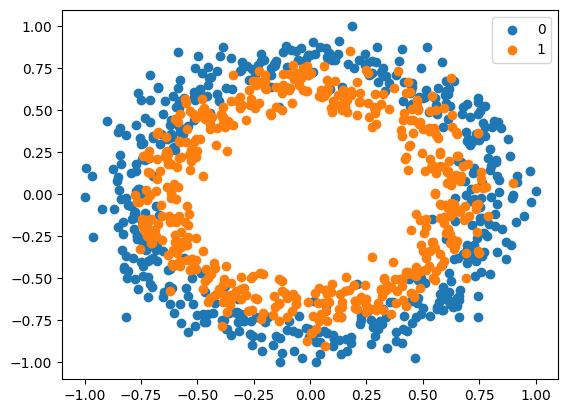

In [30]:
for i in range(2):
    samples_ix = np.where(y == i)
    pyplot.scatter(X[samples_ix, 0], X[samples_ix, 1], label=str(i))
pyplot.legend()
pyplot.show()

In [31]:
# Define model run for various model specifications
def run(model, iterations):
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    loss_fn = tf.keras.losses.BinaryCrossentropy()

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    acc_train = []
    acc_test = []
    for r in range(iterations):
        print("After {} episodes:".format((r + 1)* 10))
        history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=10, batch_size=100, verbose=0)
        acc_train.extend(history.history['accuracy'])
        acc_test.extend(history.history['val_accuracy'])

        prediction = model.predict(trainX)
        prediction = np.where(model.predict(trainX) > 0.5, 1, 0)

        for i in range(2):
            samples_ix = np.where(prediction == i)
            pyplot.scatter(X[samples_ix, 0], X[samples_ix, 1], label=str(i))
        pyplot.legend()
        pyplot.show()

    pyplot.plot(acc_train, label='train')
    pyplot.plot(acc_test, label='test')
    pyplot.legend()
    pyplot.show()
    
    print('Evaluation')
    model.evaluate(testX, testy)

### Models with ReLU

After 10 episodes:


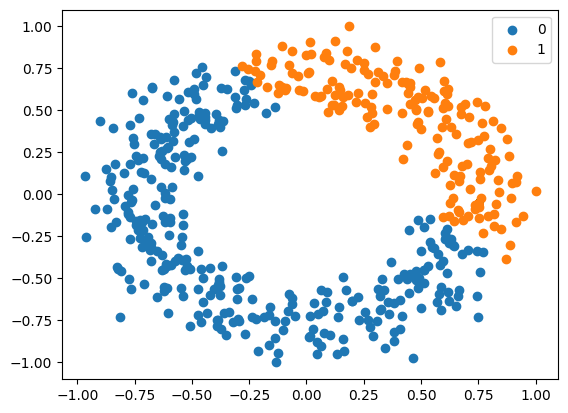

After 20 episodes:


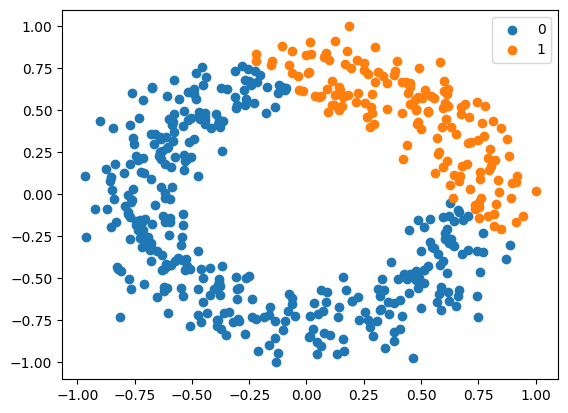

After 30 episodes:


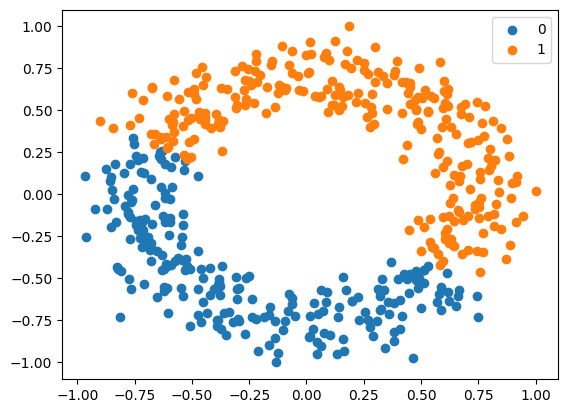

After 40 episodes:


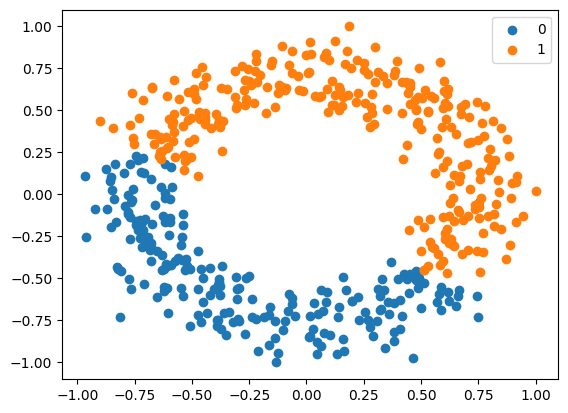

After 50 episodes:


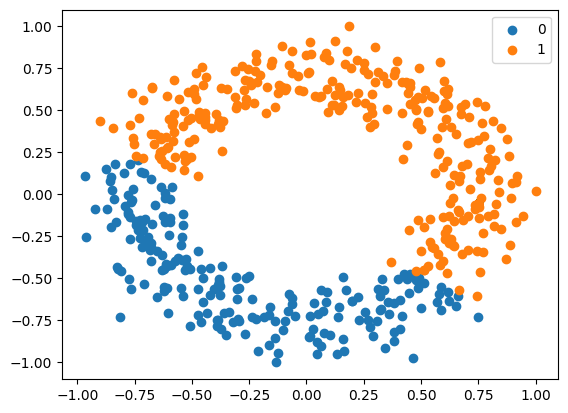

After 60 episodes:


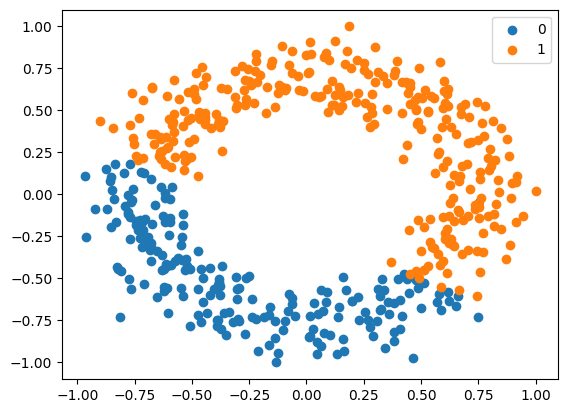

After 70 episodes:


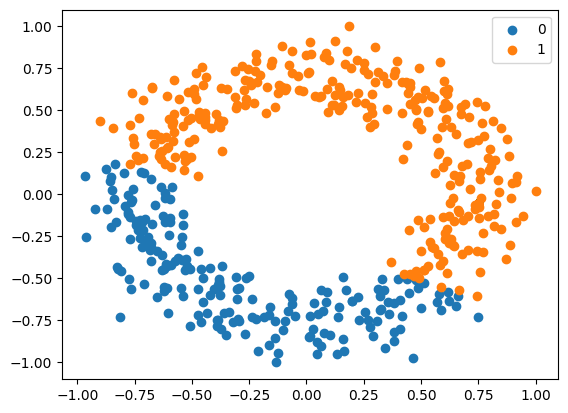

After 80 episodes:


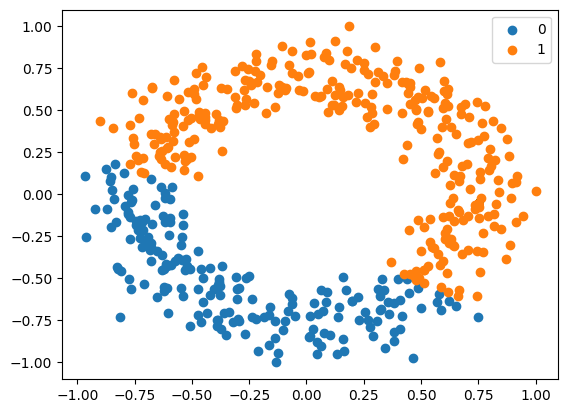

After 90 episodes:


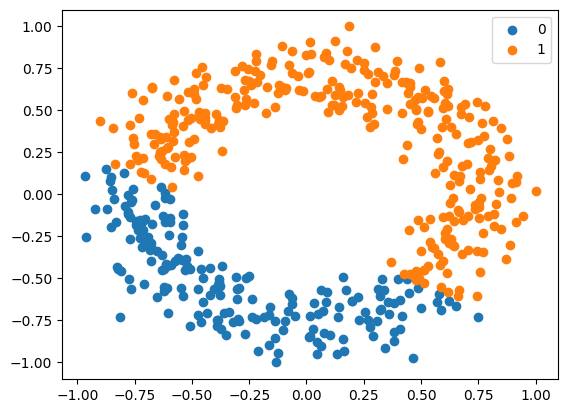

After 100 episodes:


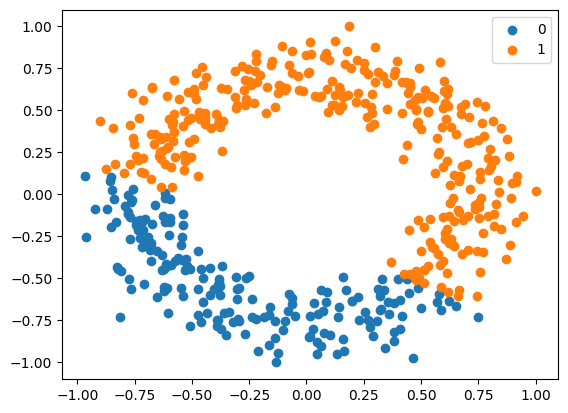

After 110 episodes:


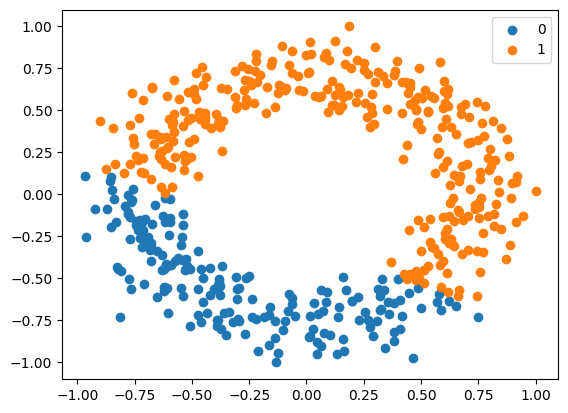

After 120 episodes:


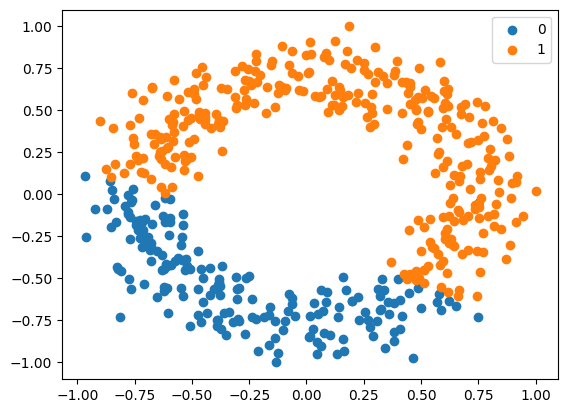

After 130 episodes:


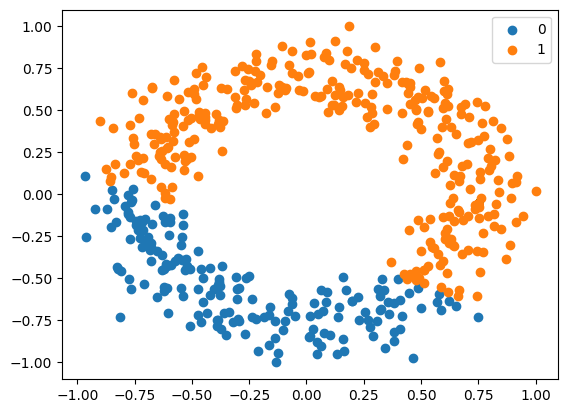

After 140 episodes:


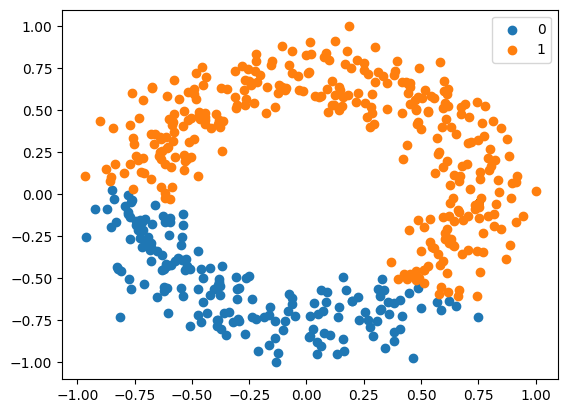

After 150 episodes:


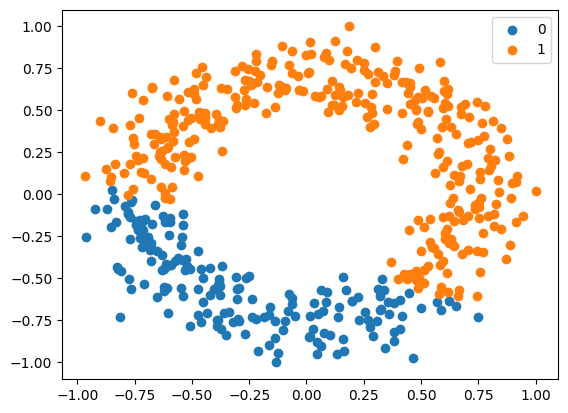

After 160 episodes:


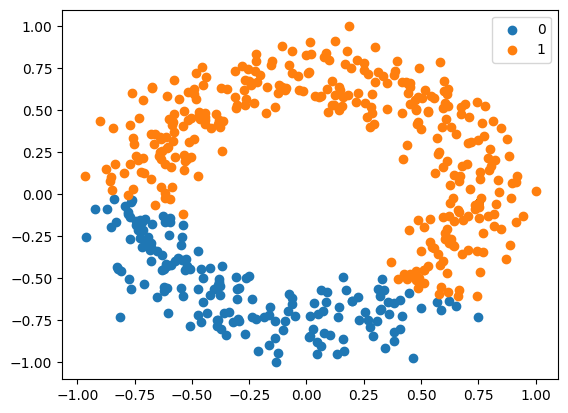

After 170 episodes:


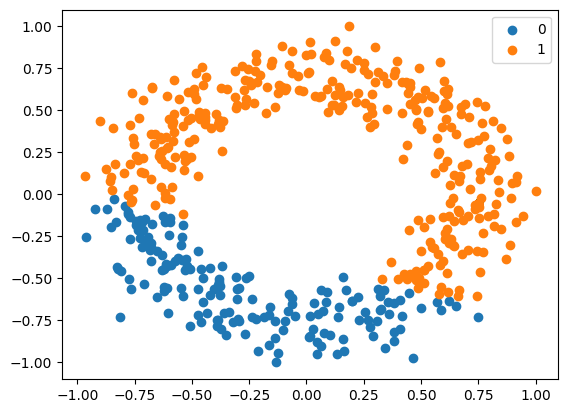

After 180 episodes:


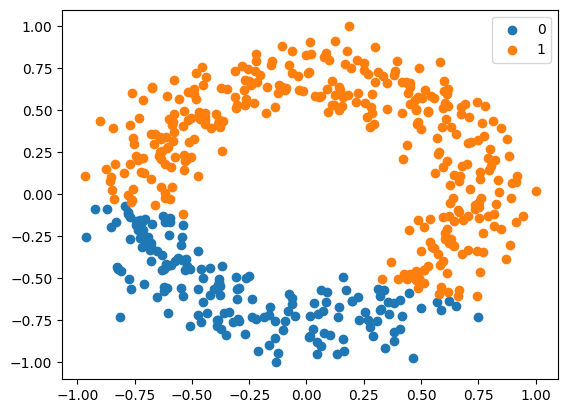

After 190 episodes:


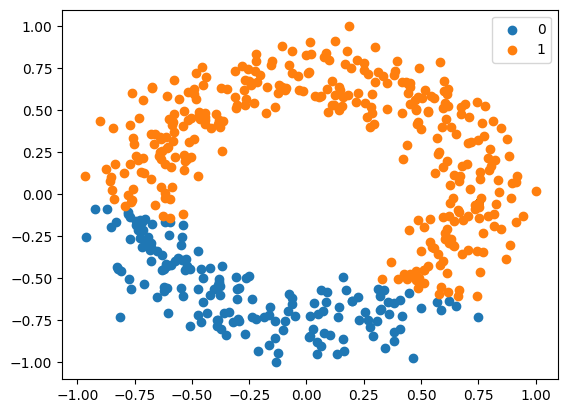

After 200 episodes:


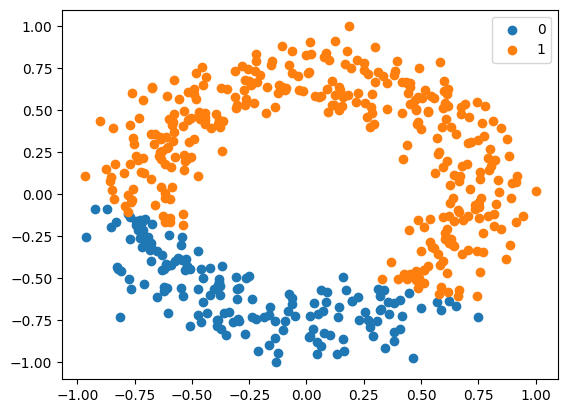

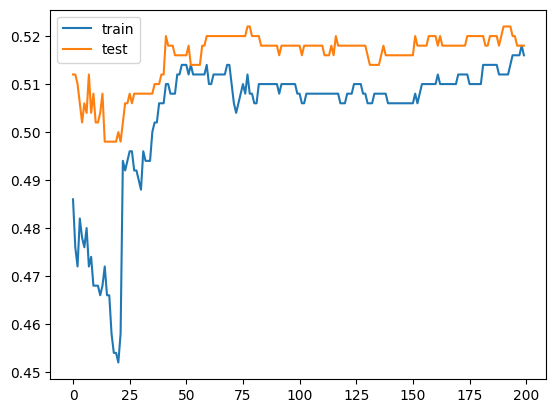

Evaluation
16/16 [==============================] - 0s 1ms/step - loss: 0.6852 - accuracy: 0.5180


In [32]:
tf.random.set_seed(42)

init = tf.keras.initializers.GlorotNormal()

inputs = tf.keras.Input(shape=(2,), name="input_values")
h = tf.keras.layers.Dense(2, activation="relu", kernel_initializer=init)(inputs)
outputs = tf.keras.layers.Dense(1)(h)
outputs = tf.keras.activations.sigmoid(outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

run(model, 20)

In [33]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
loss_fn = tf.keras.losses.BinaryCrossentropy()

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

acc_train = []
acc_test = []

After 10 episodes:


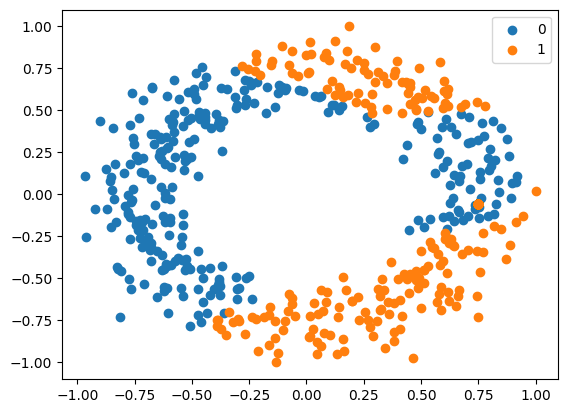

After 20 episodes:


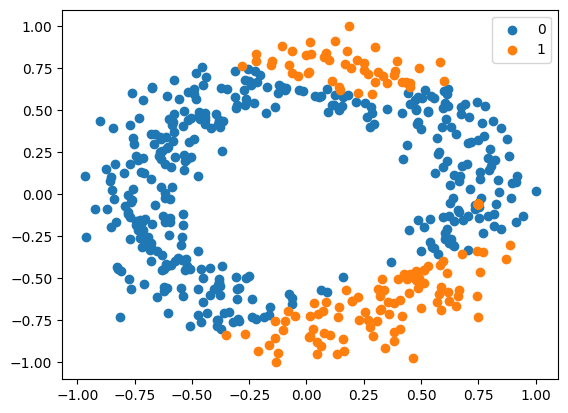

After 30 episodes:


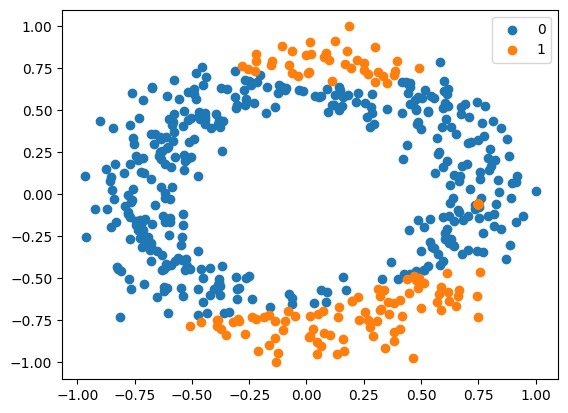

After 40 episodes:


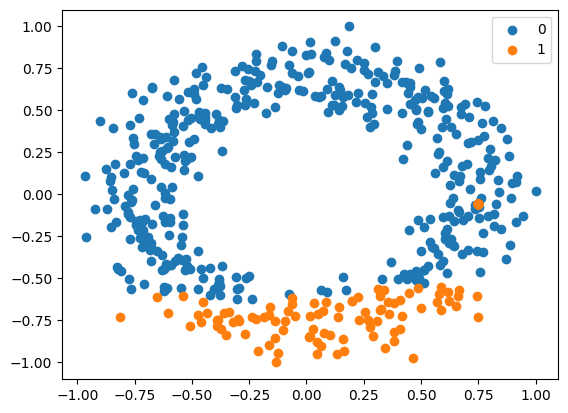

After 50 episodes:


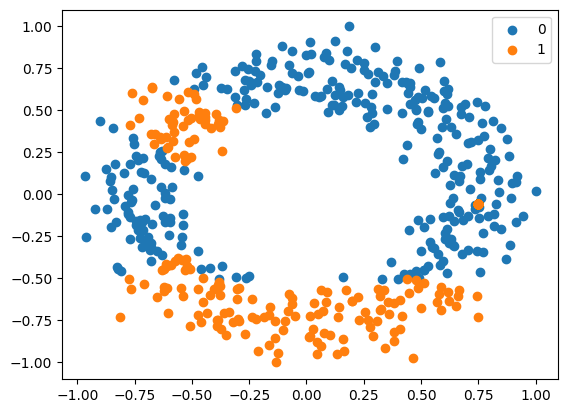

After 60 episodes:


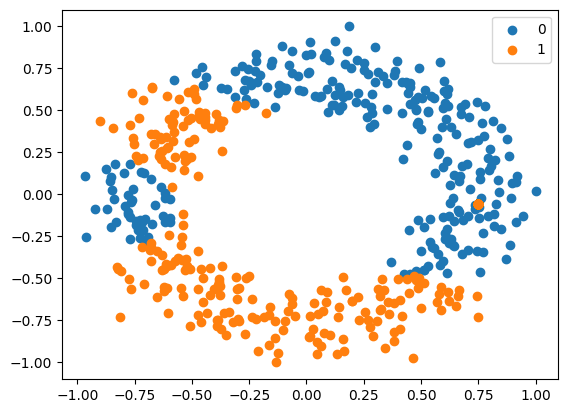

After 70 episodes:


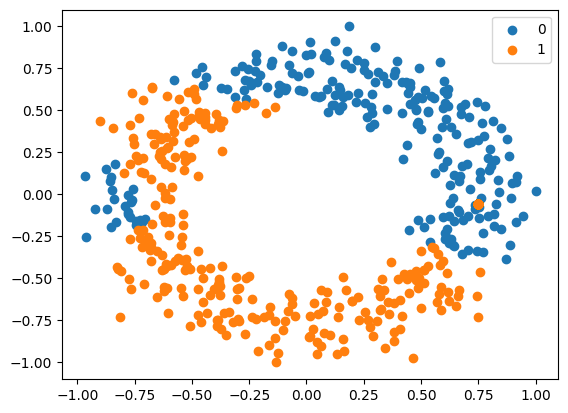

After 80 episodes:


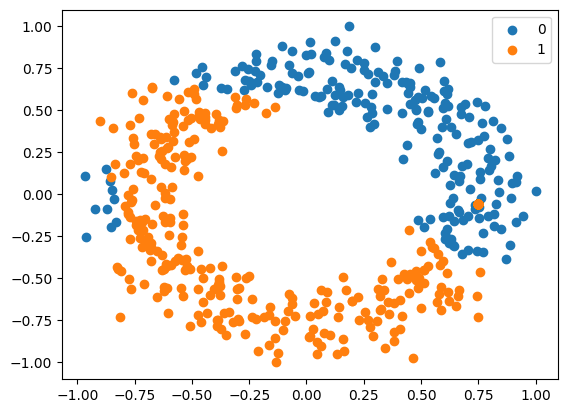

After 90 episodes:


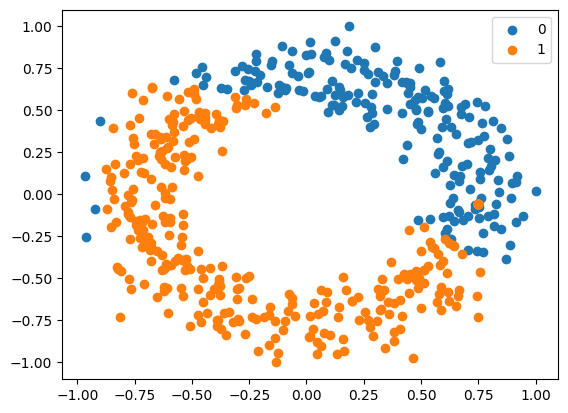

After 100 episodes:


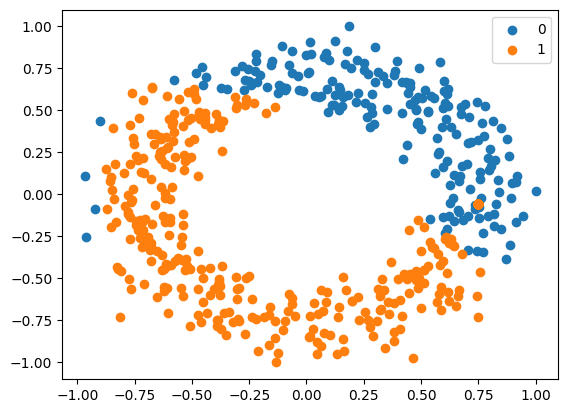

After 110 episodes:


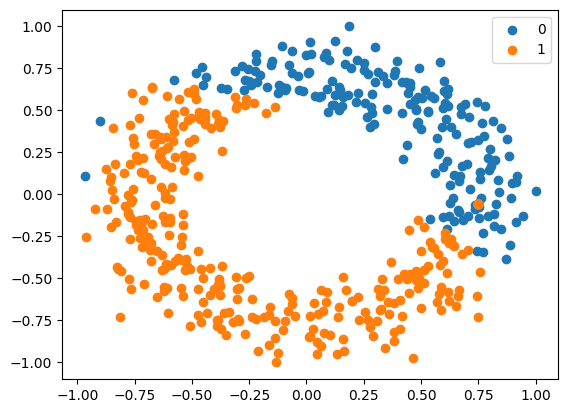

After 120 episodes:


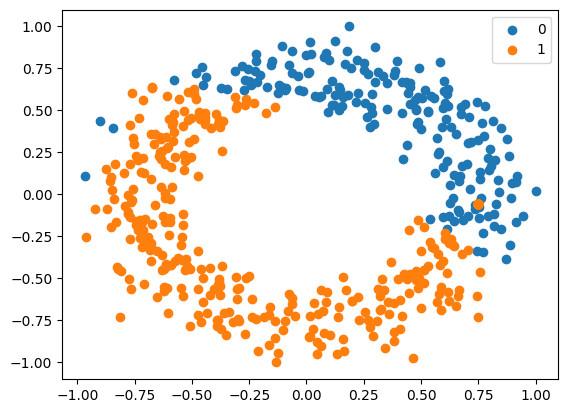

After 130 episodes:


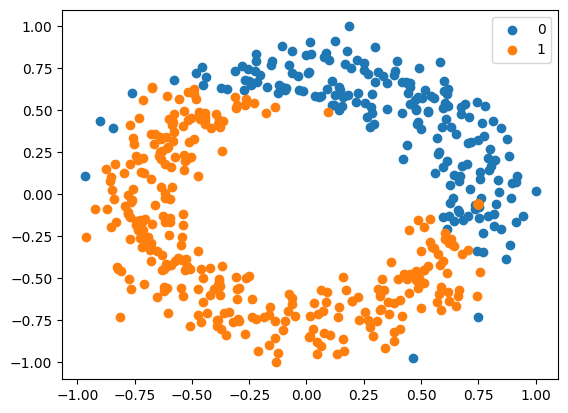

After 140 episodes:


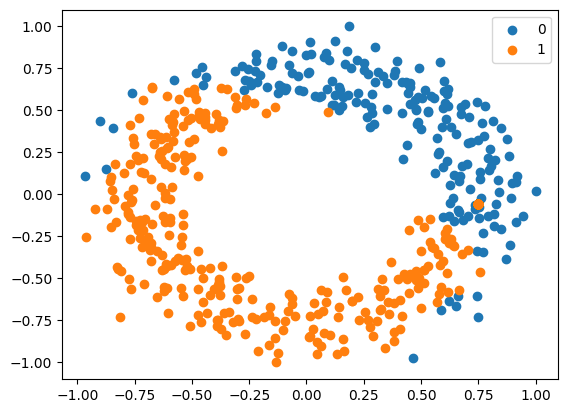

After 150 episodes:


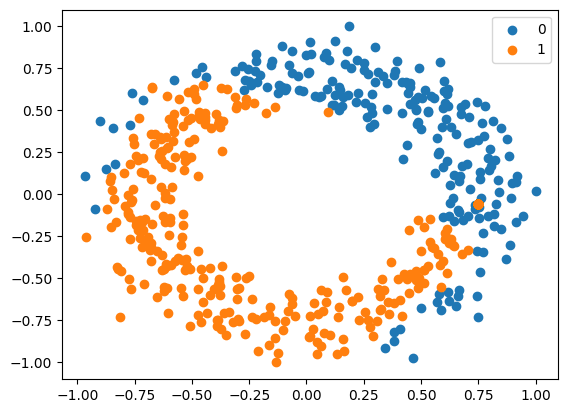

After 160 episodes:


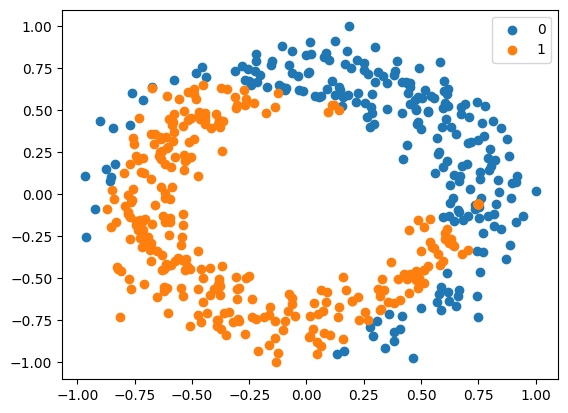

After 170 episodes:


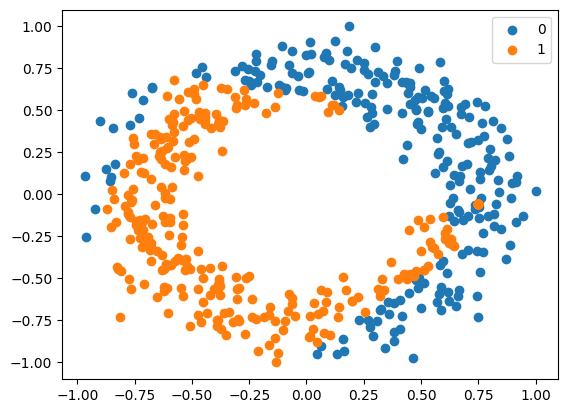

After 180 episodes:


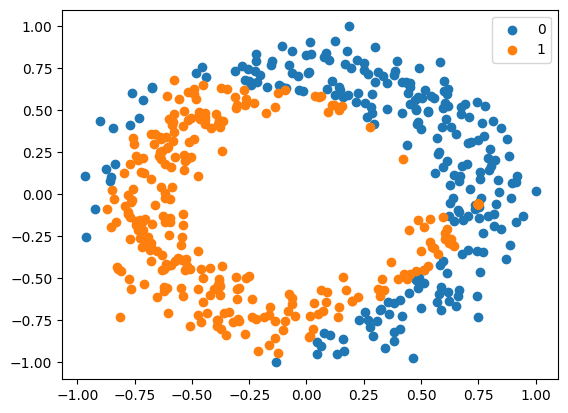

After 190 episodes:


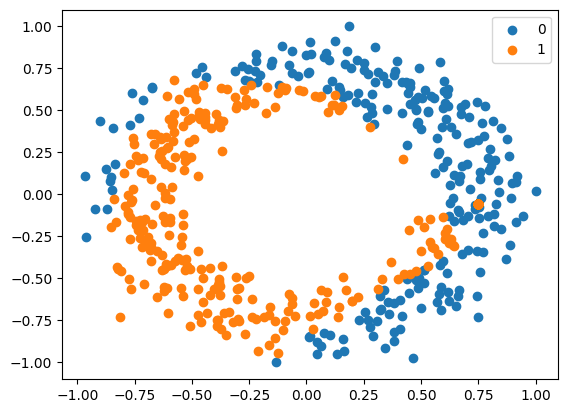

After 200 episodes:


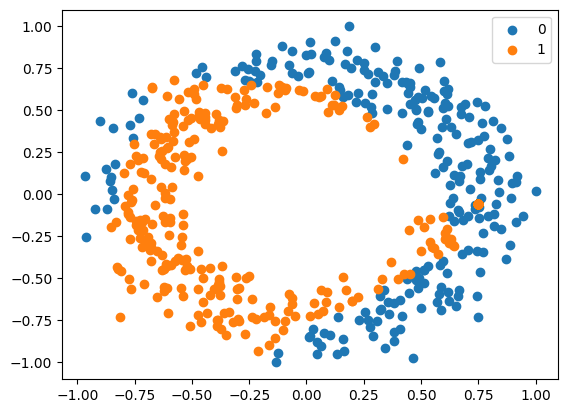

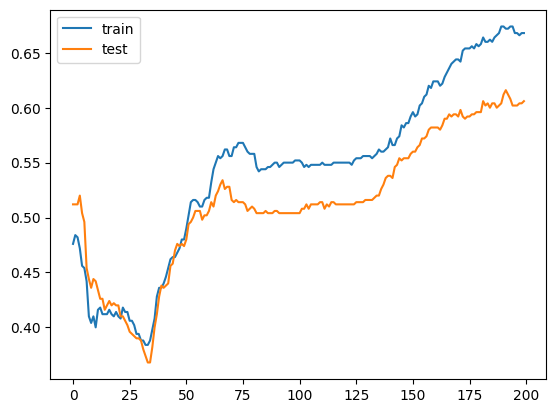

Evaluation
16/16 [==============================] - 0s 1ms/step - loss: 0.6640 - accuracy: 0.6060


In [34]:
tf.random.set_seed(42)

init = tf.keras.initializers.GlorotNormal()

inputs = tf.keras.Input(shape=(2,), name="input_values")
h = tf.keras.layers.Dense(10, activation="relu", kernel_initializer=init)(inputs)
outputs = tf.keras.layers.Dense(1)(h)
outputs = tf.keras.activations.sigmoid(outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

run(model, 20)

After 10 episodes:


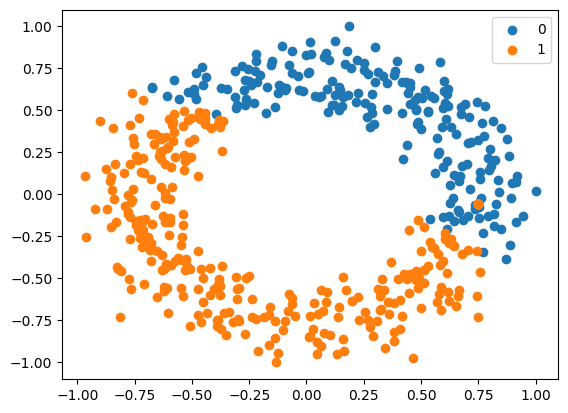

After 20 episodes:


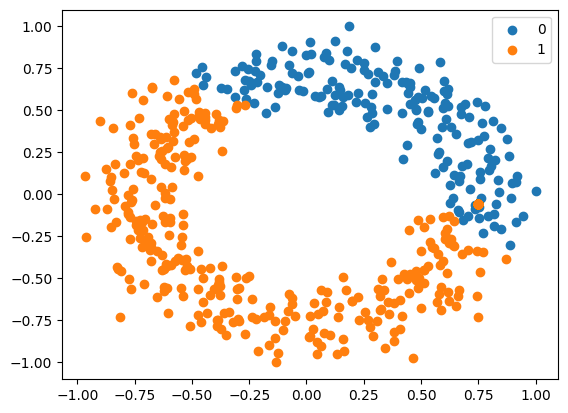

After 30 episodes:


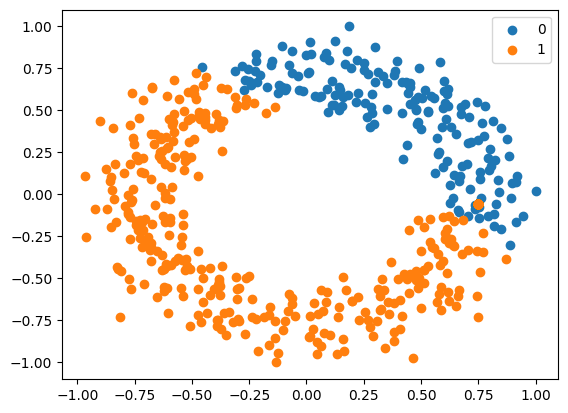

After 40 episodes:


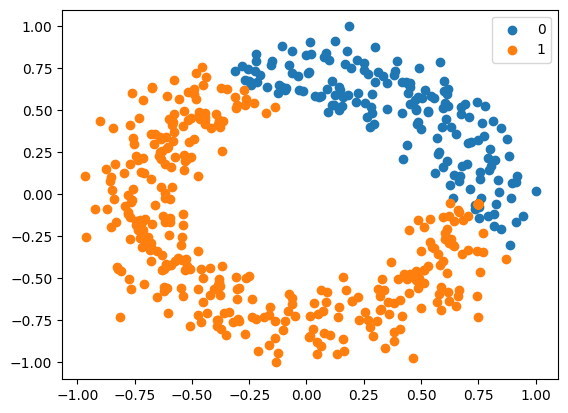

After 50 episodes:


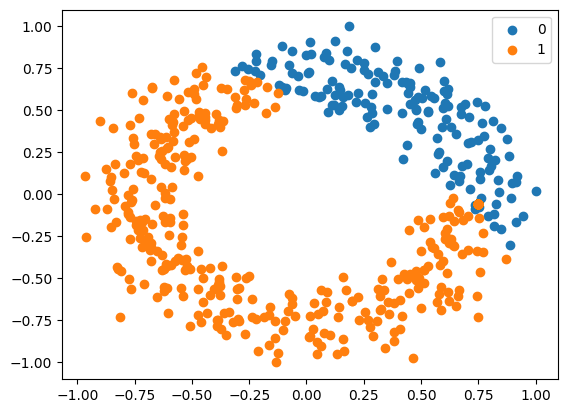

After 60 episodes:


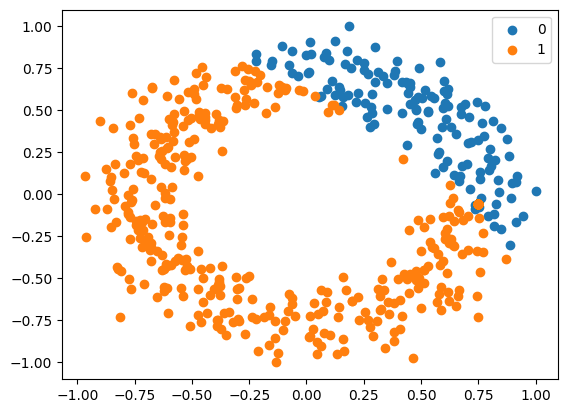

After 70 episodes:


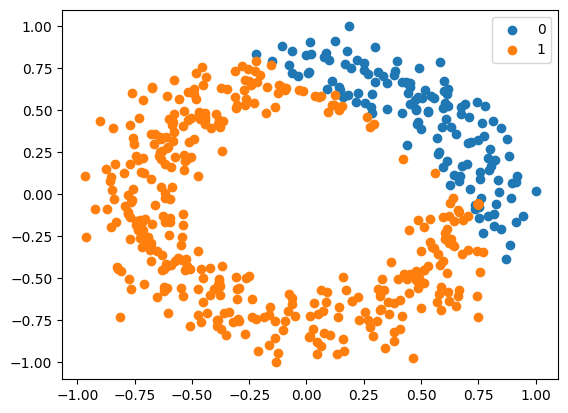

After 80 episodes:


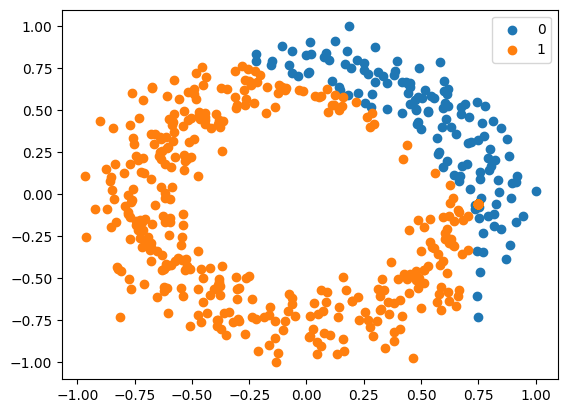

After 90 episodes:


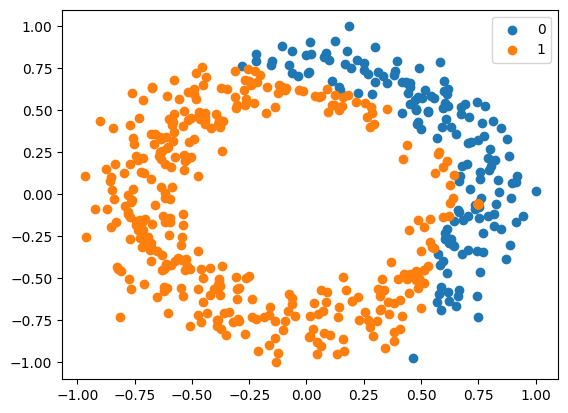

After 100 episodes:


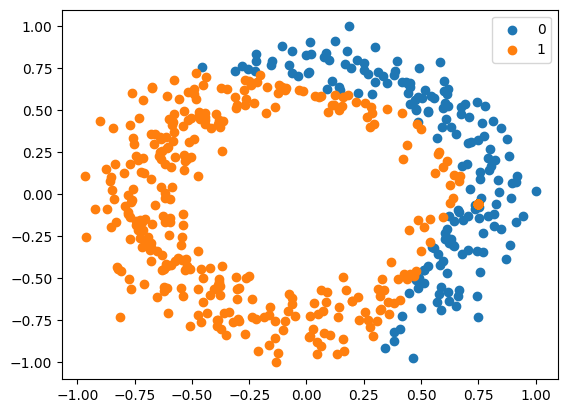

After 110 episodes:


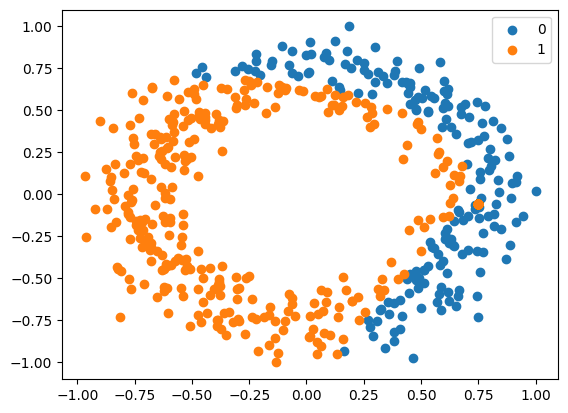

After 120 episodes:


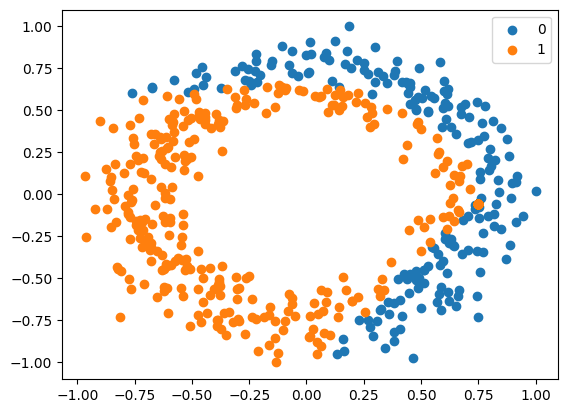

After 130 episodes:


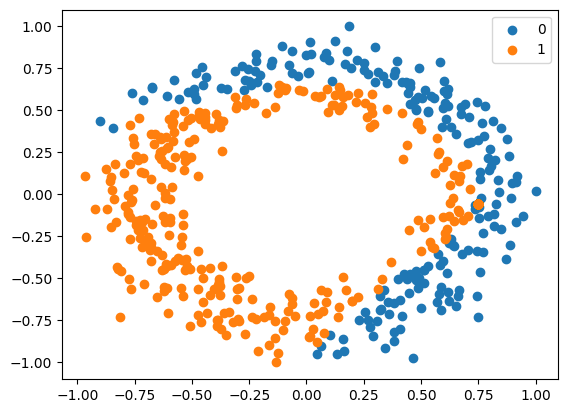

After 140 episodes:


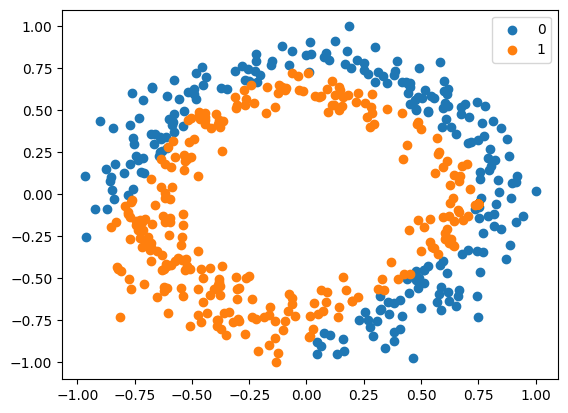

After 150 episodes:


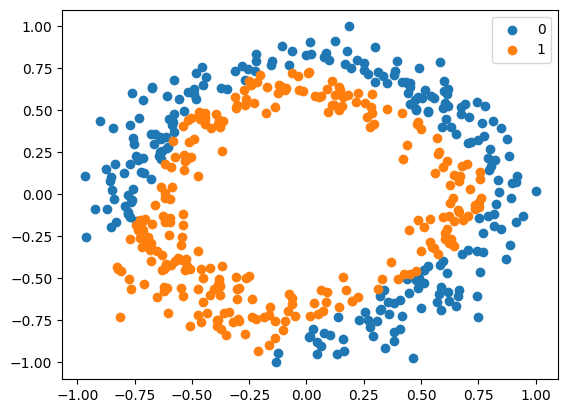

After 160 episodes:


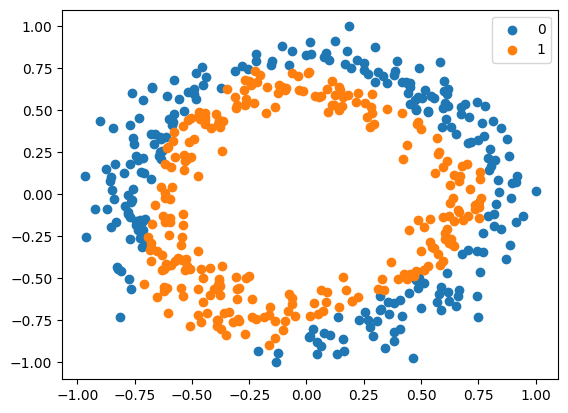

After 170 episodes:


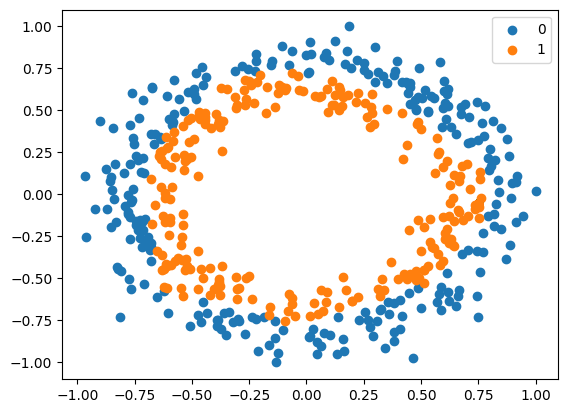

After 180 episodes:


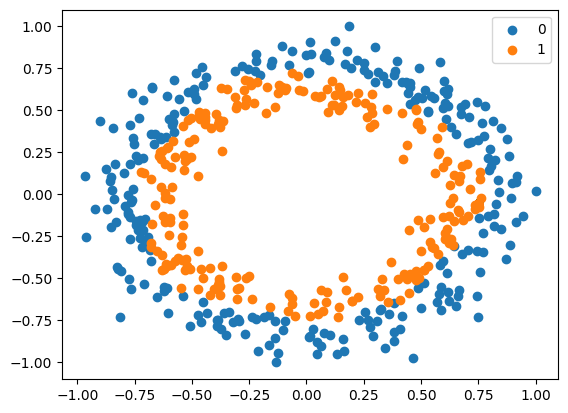

After 190 episodes:


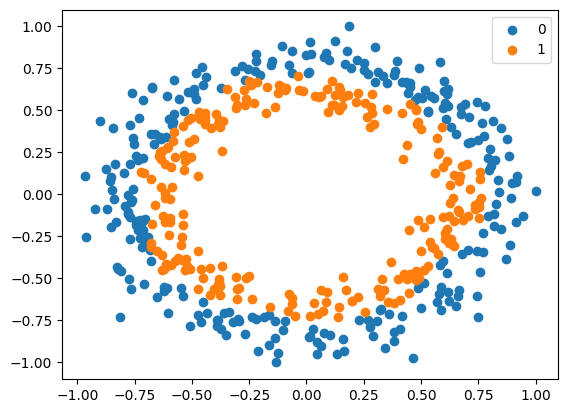

After 200 episodes:


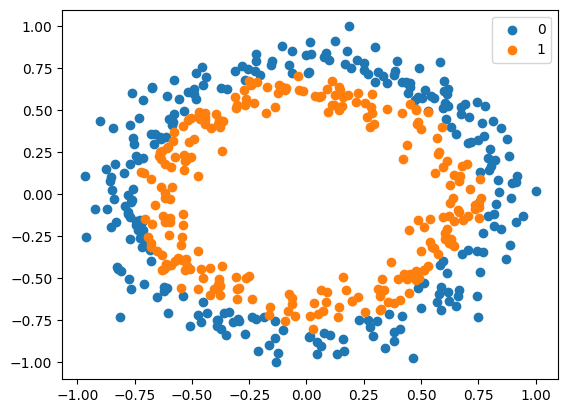

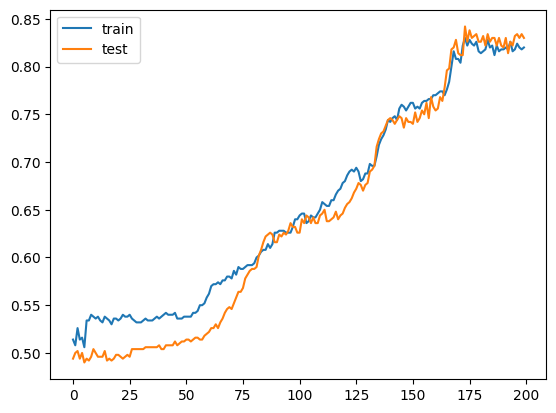

Evaluation
16/16 [==============================] - 0s 1ms/step - loss: 0.4094 - accuracy: 0.8300


In [35]:
tf.random.set_seed(42)

init = tf.keras.initializers.RandomUniform(minval=0, maxval=1)

inputs = tf.keras.Input(shape=(2,), name="input_values")
h = tf.keras.layers.Dense(5, activation="relu", kernel_initializer=init)(inputs)
h = tf.keras.layers.Dense(5, activation="relu", kernel_initializer=init)(h)
h = tf.keras.layers.Dense(5, activation="relu", kernel_initializer=init)(h)
outputs = tf.keras.layers.Dense(1)(h)
outputs = tf.keras.activations.sigmoid(outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

run(model, 20)

After 10 episodes:


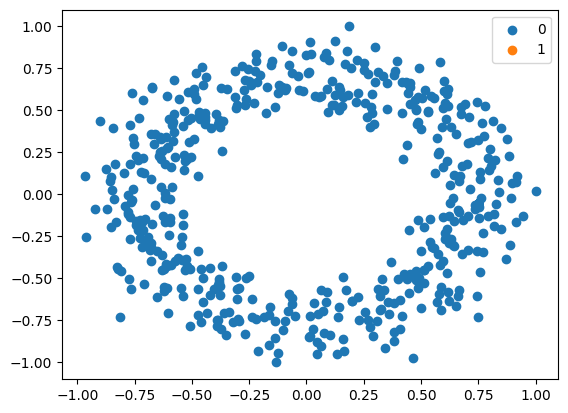

After 20 episodes:


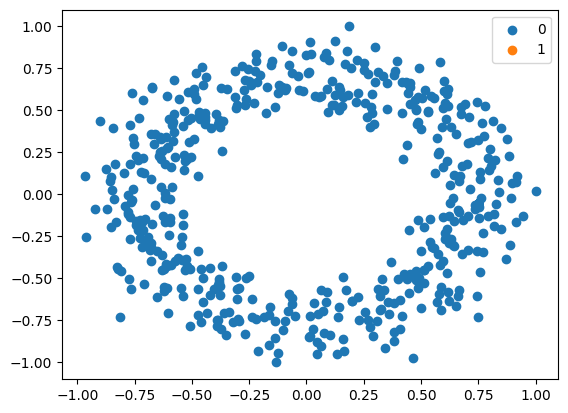

After 30 episodes:


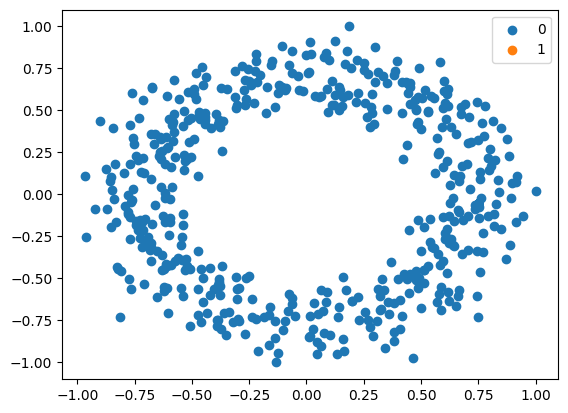

After 40 episodes:


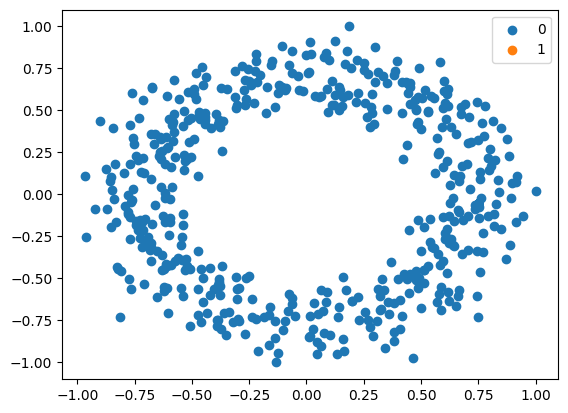

After 50 episodes:


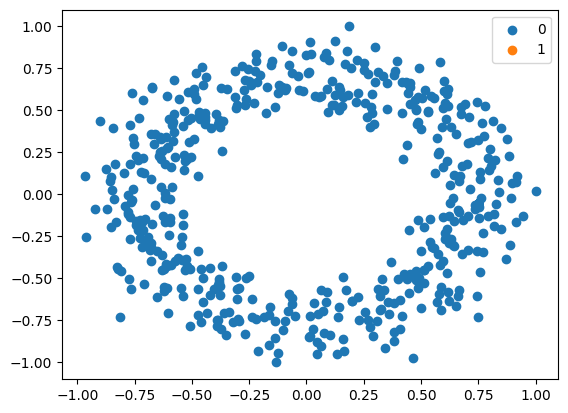

After 60 episodes:


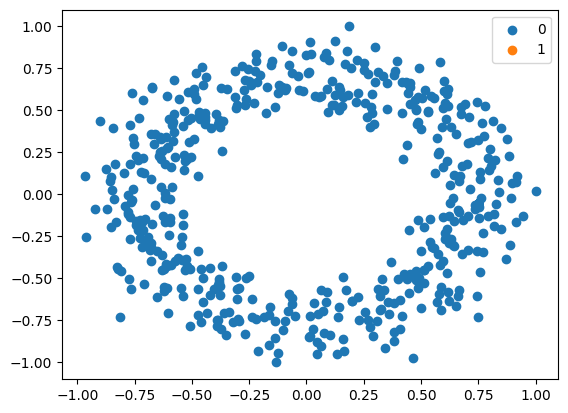

After 70 episodes:


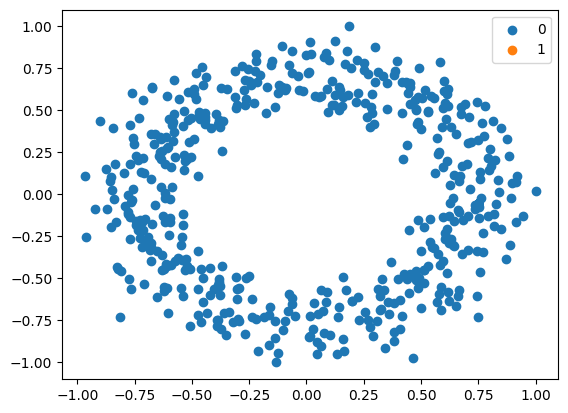

After 80 episodes:


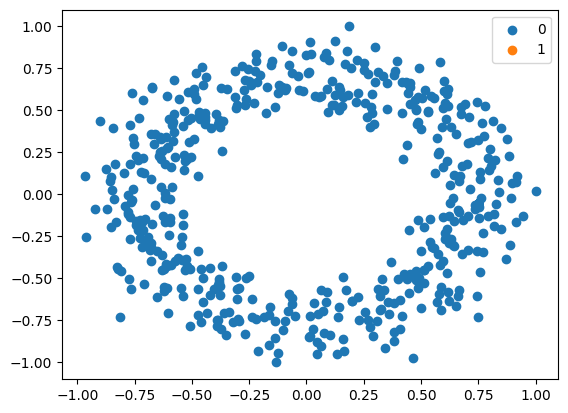

After 90 episodes:


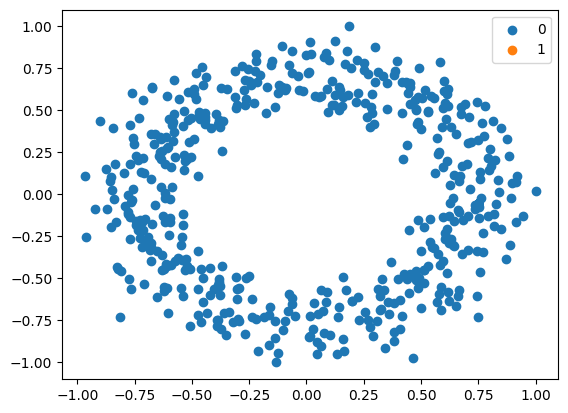

After 100 episodes:


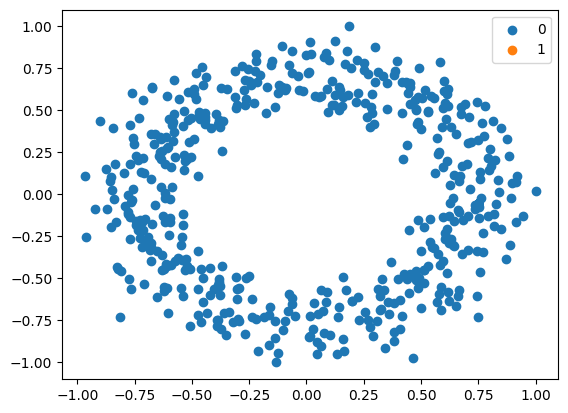

After 110 episodes:


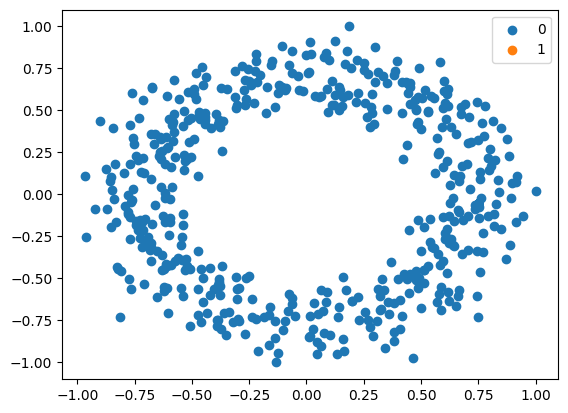

After 120 episodes:


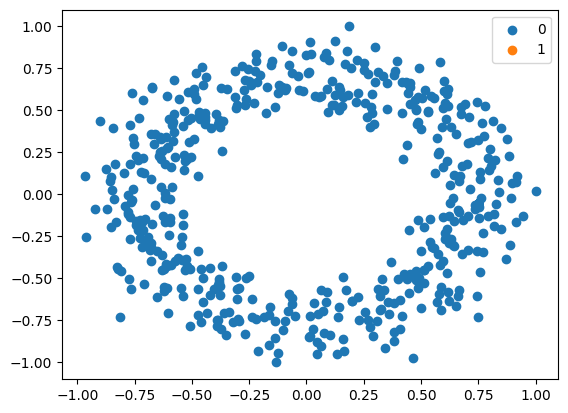

After 130 episodes:


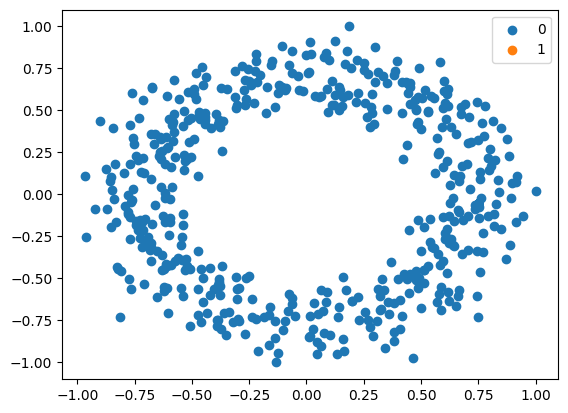

After 140 episodes:


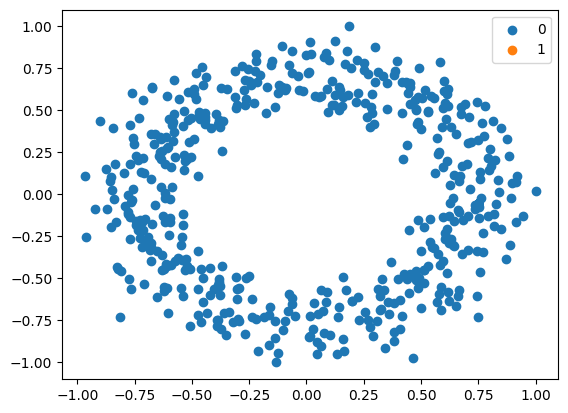

After 150 episodes:


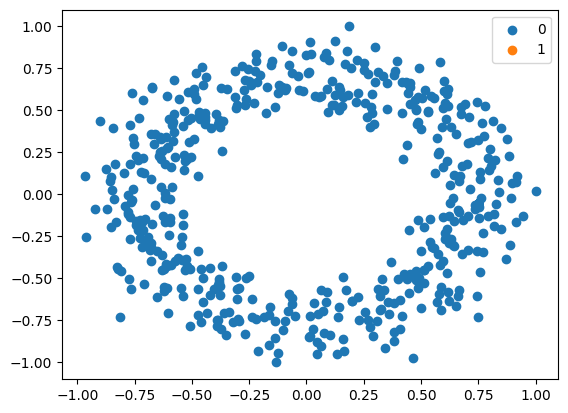

After 160 episodes:


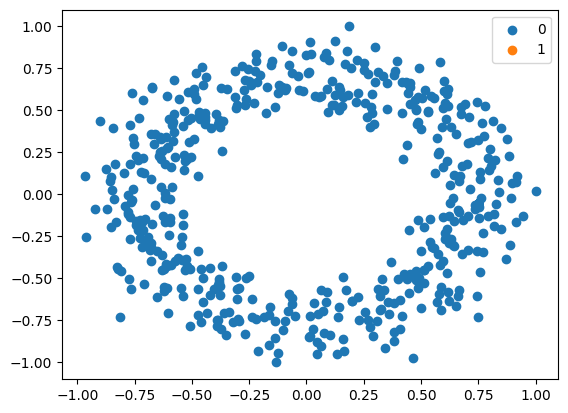

After 170 episodes:


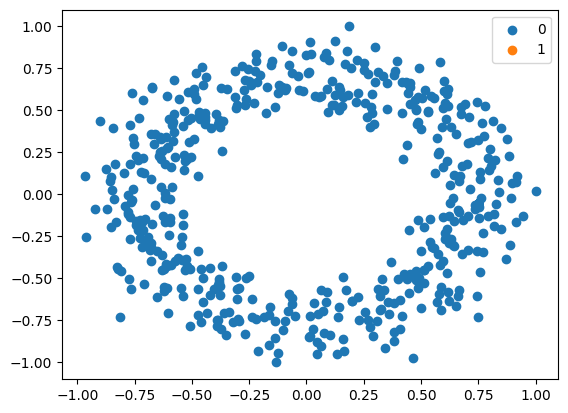

After 180 episodes:


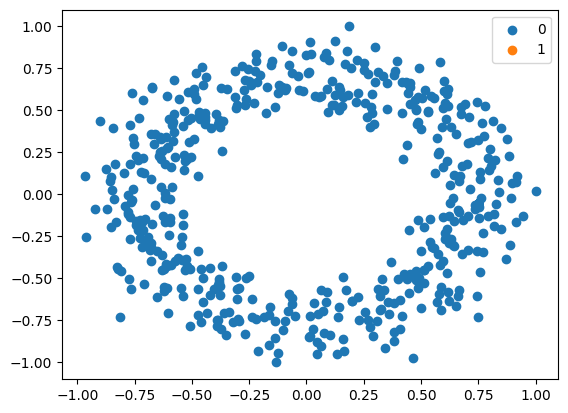

After 190 episodes:


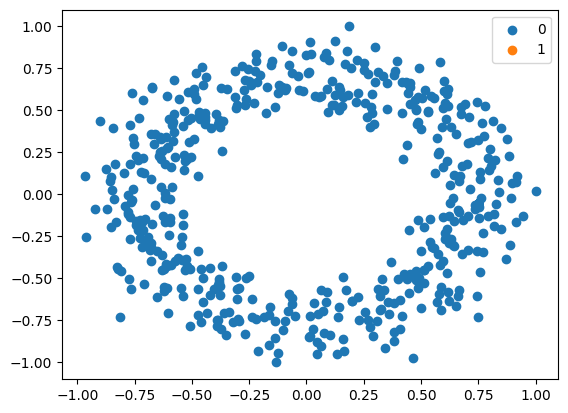

After 200 episodes:


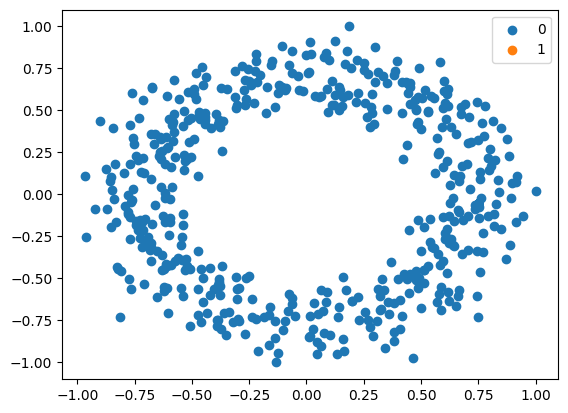

After 210 episodes:


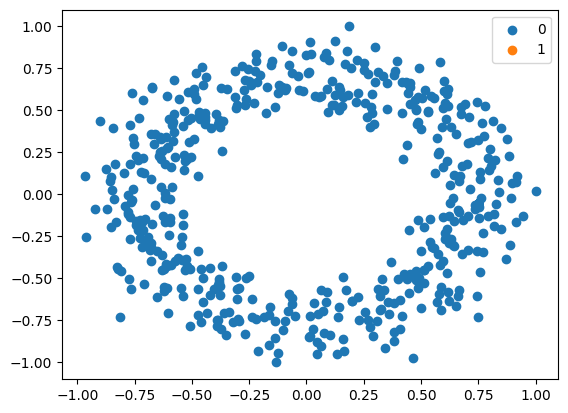

After 220 episodes:


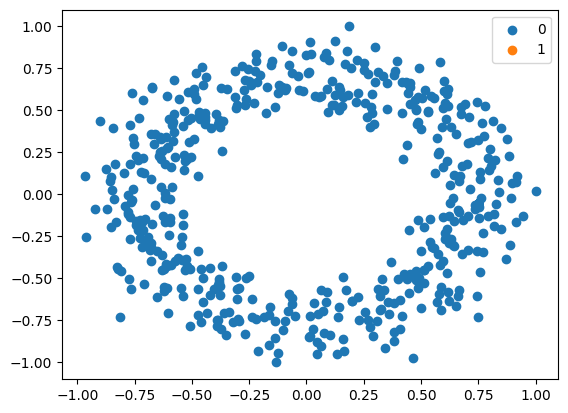

After 230 episodes:


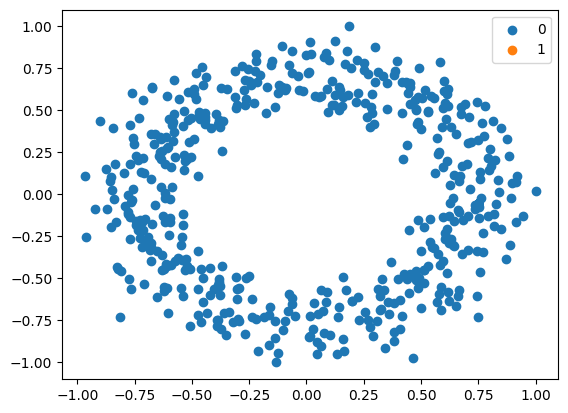

After 240 episodes:


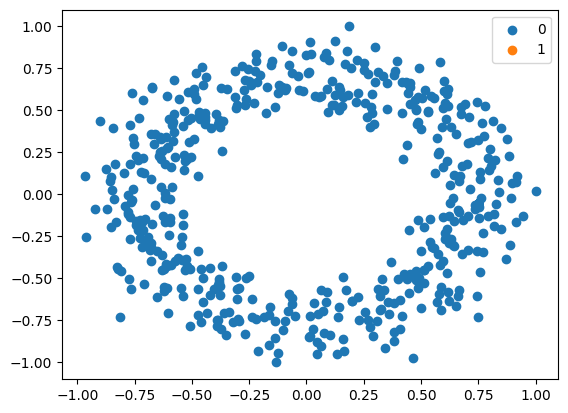

After 250 episodes:


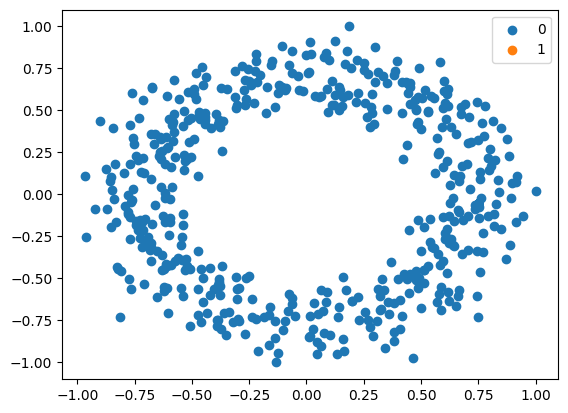

After 260 episodes:


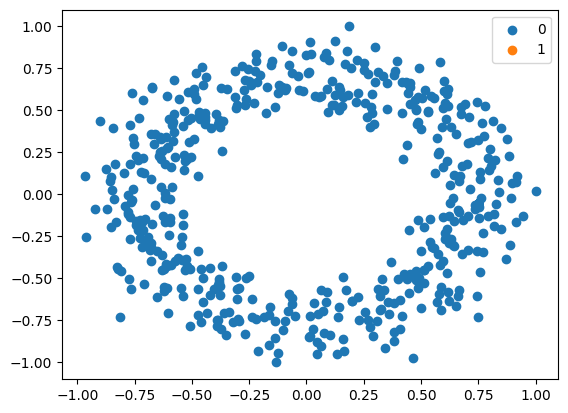

After 270 episodes:


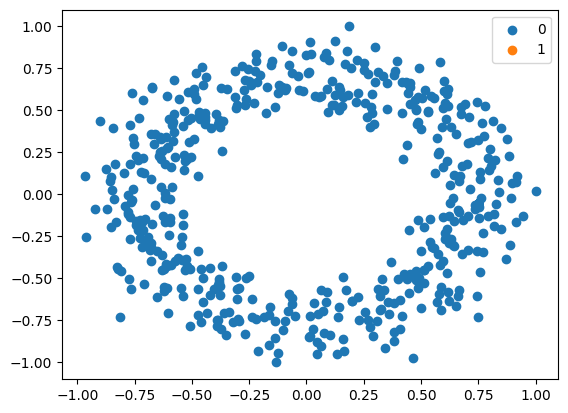

After 280 episodes:


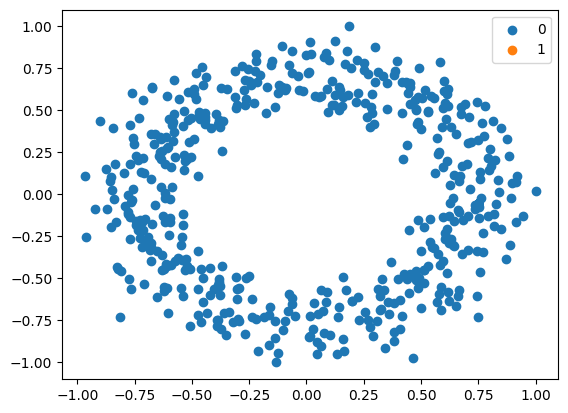

After 290 episodes:


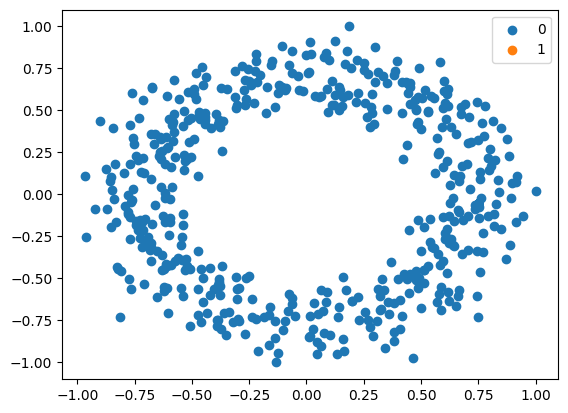

After 300 episodes:


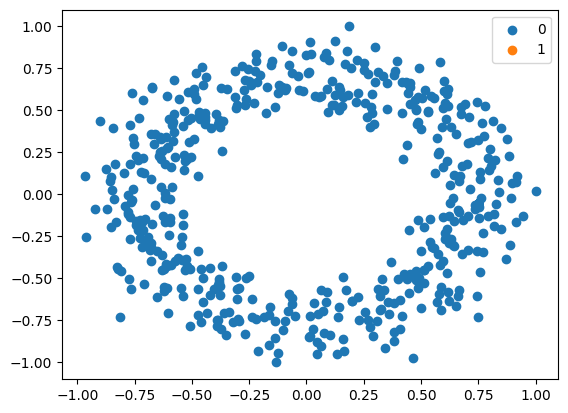

After 310 episodes:


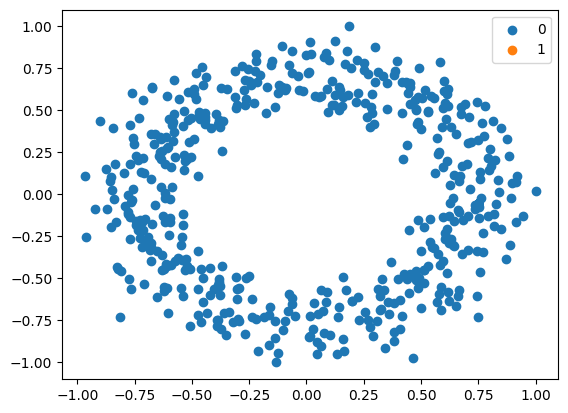

After 320 episodes:


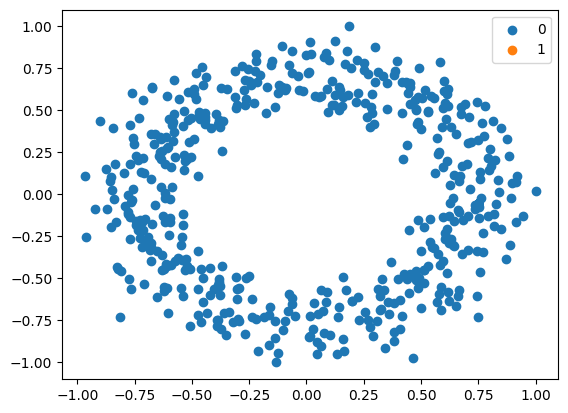

After 330 episodes:


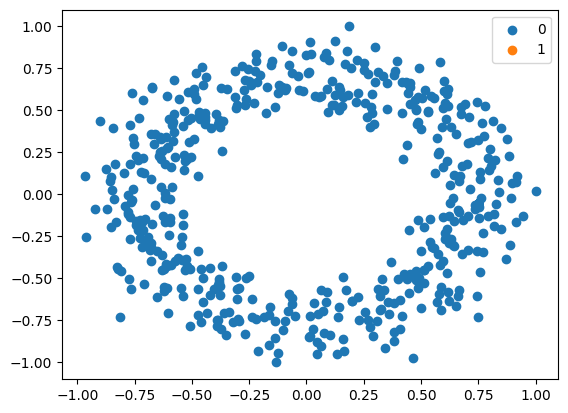

After 340 episodes:


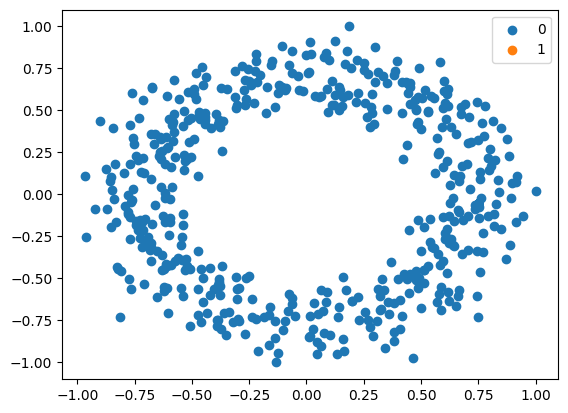

After 350 episodes:


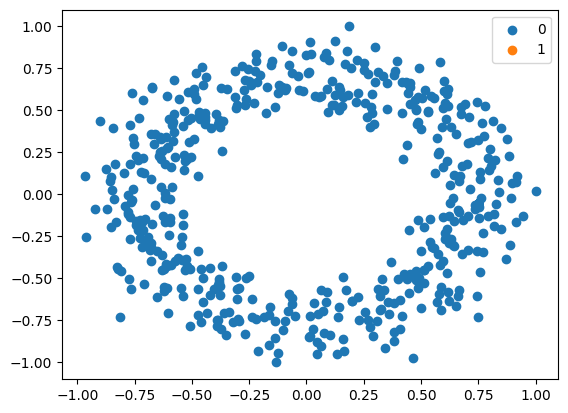

After 360 episodes:


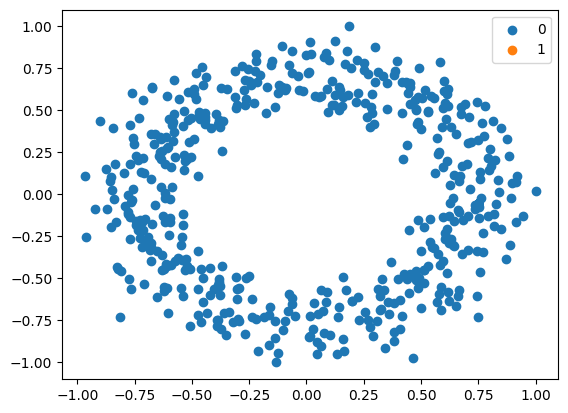

After 370 episodes:


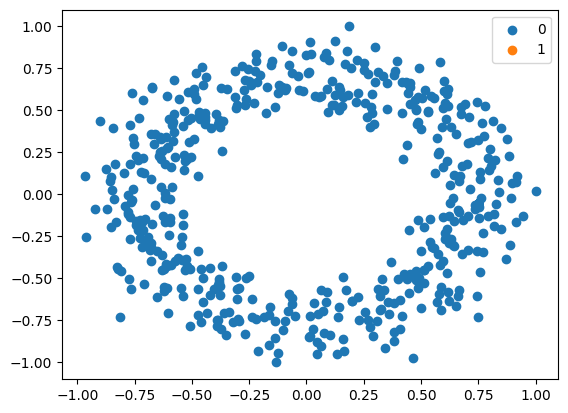

After 380 episodes:


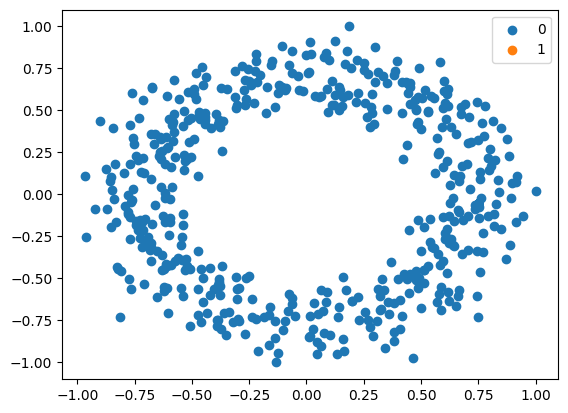

After 390 episodes:


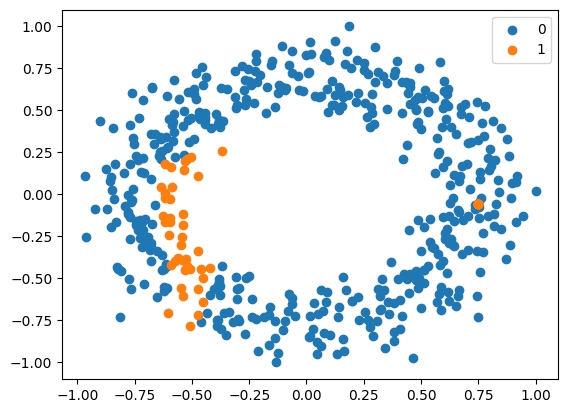

After 400 episodes:


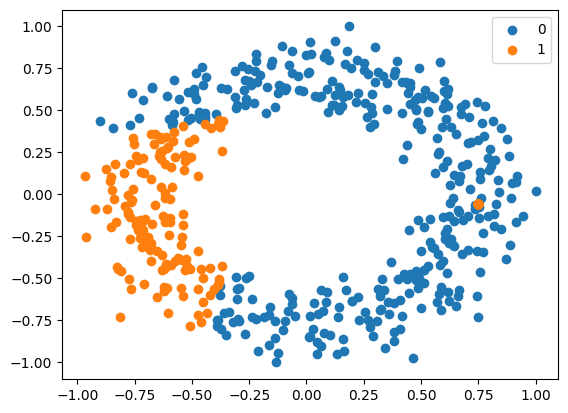

After 410 episodes:


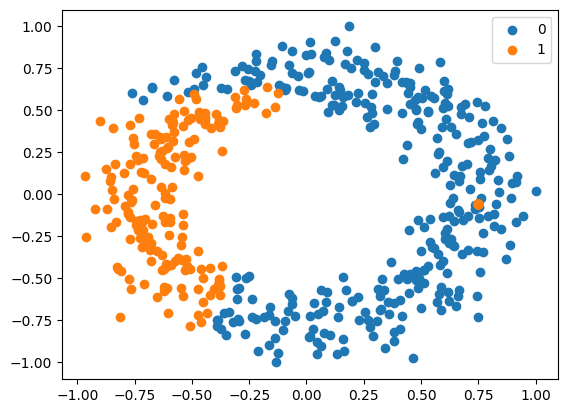

After 420 episodes:


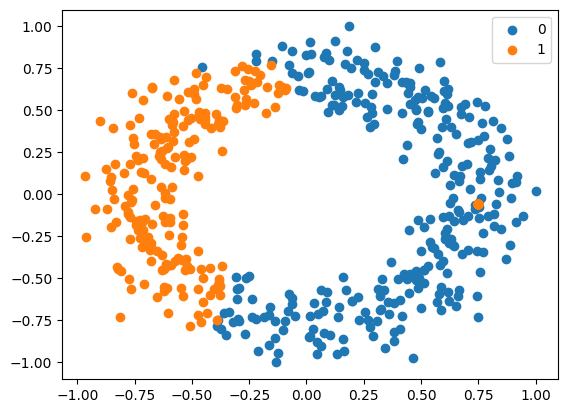

After 430 episodes:


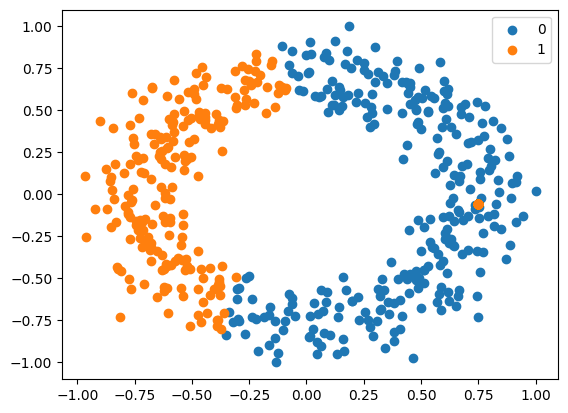

After 440 episodes:


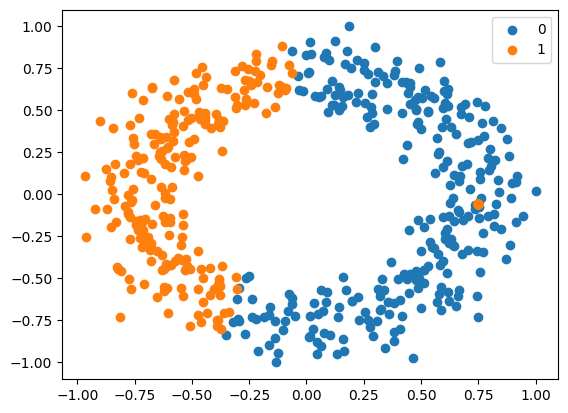

After 450 episodes:


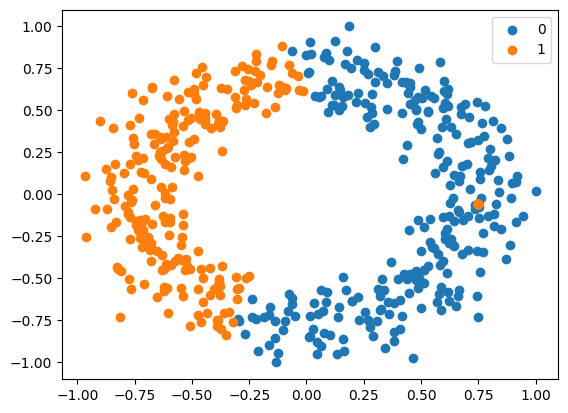

After 460 episodes:


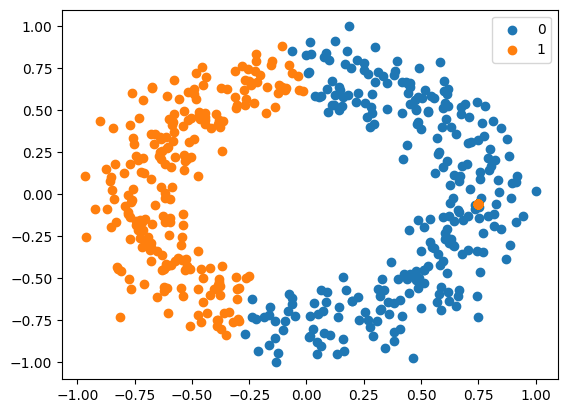

After 470 episodes:


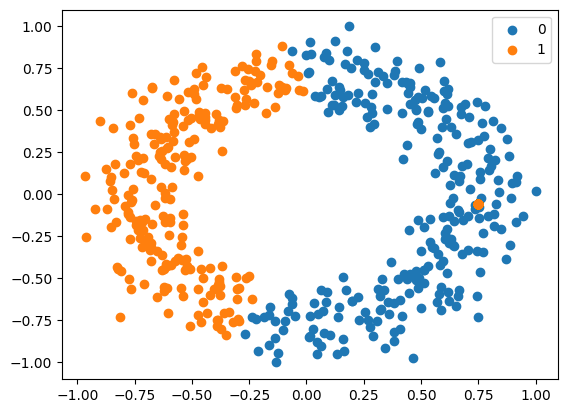

After 480 episodes:


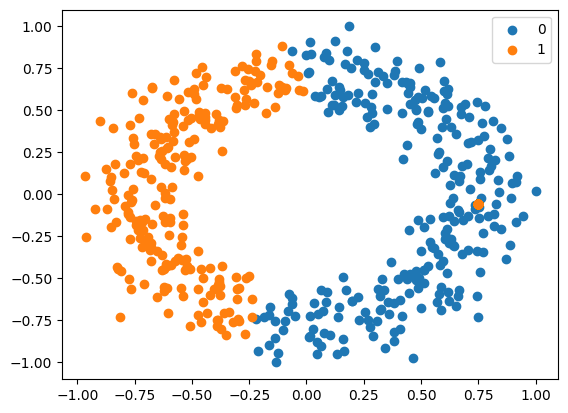

After 490 episodes:


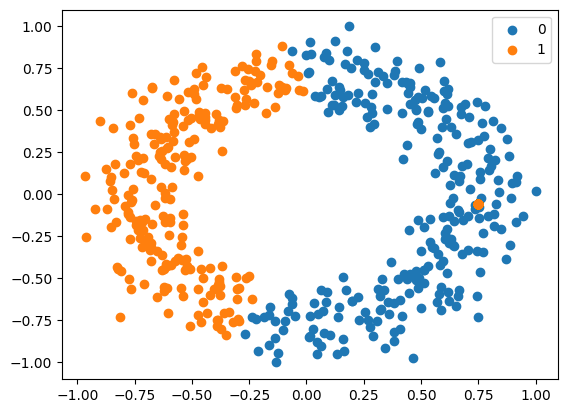

After 500 episodes:


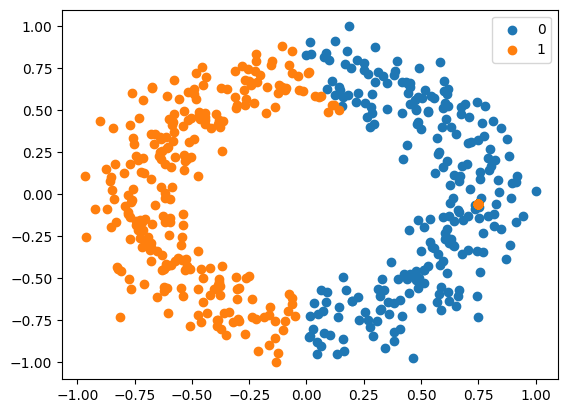

After 510 episodes:


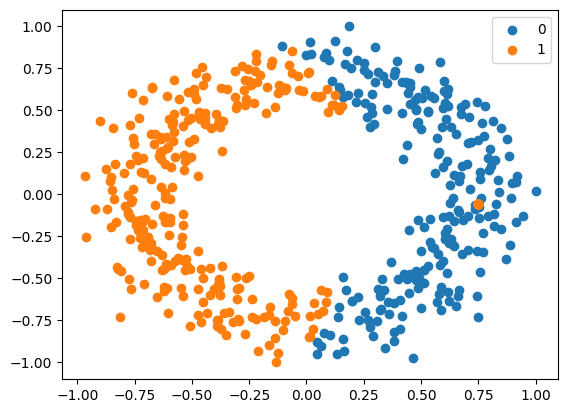

After 520 episodes:


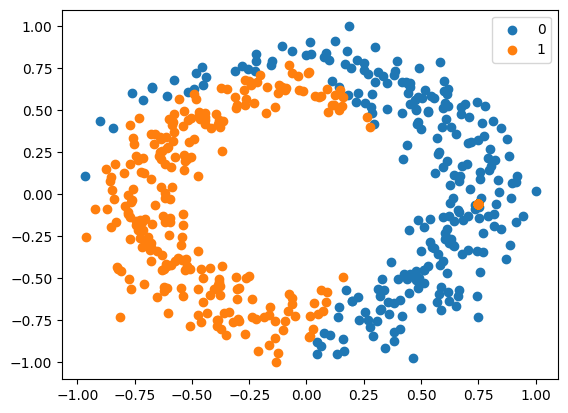

After 530 episodes:


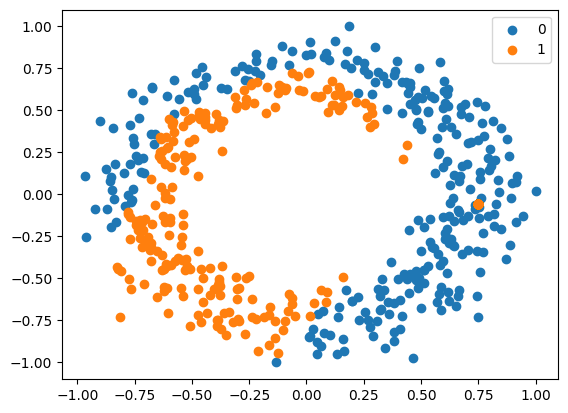

After 540 episodes:


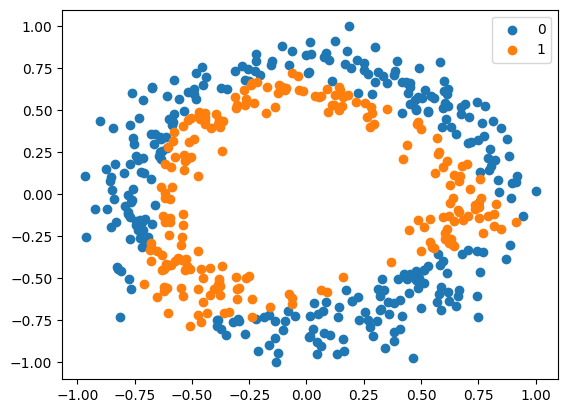

After 550 episodes:


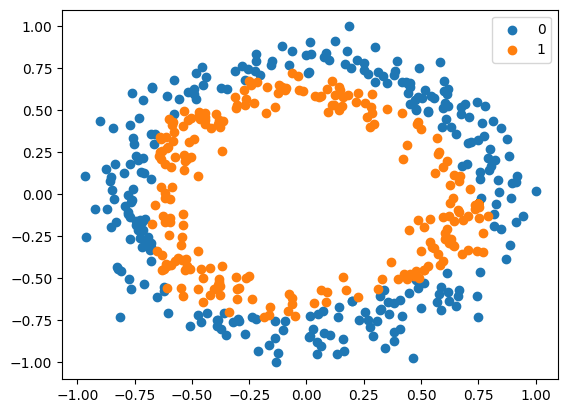

After 560 episodes:


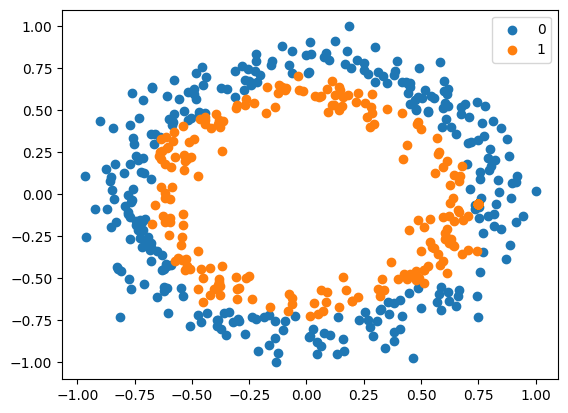

After 570 episodes:


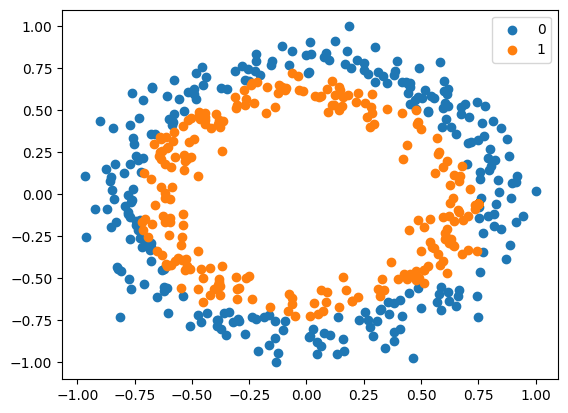

After 580 episodes:


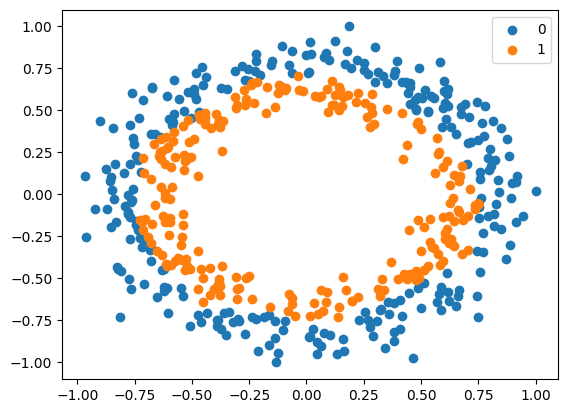

After 590 episodes:


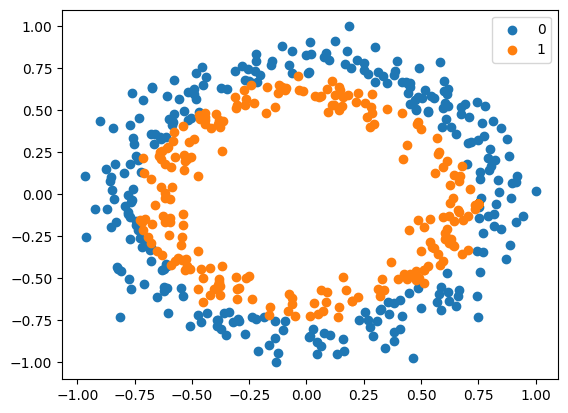

After 600 episodes:


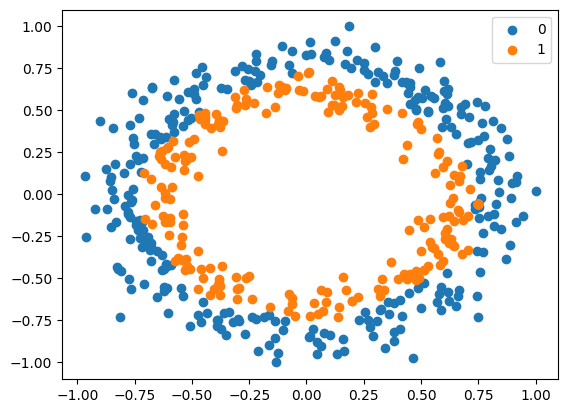

After 610 episodes:


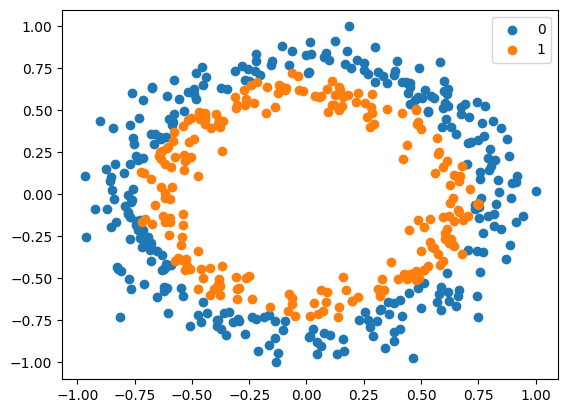

After 620 episodes:


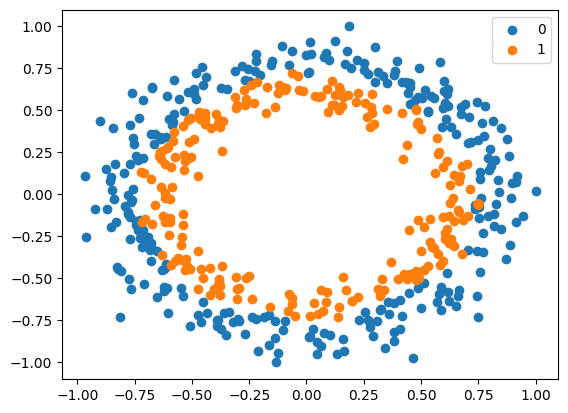

After 630 episodes:


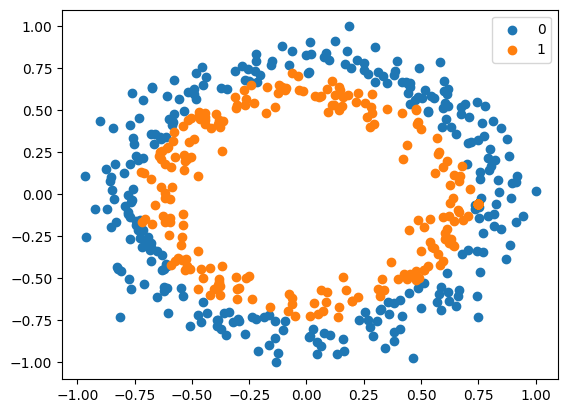

After 640 episodes:


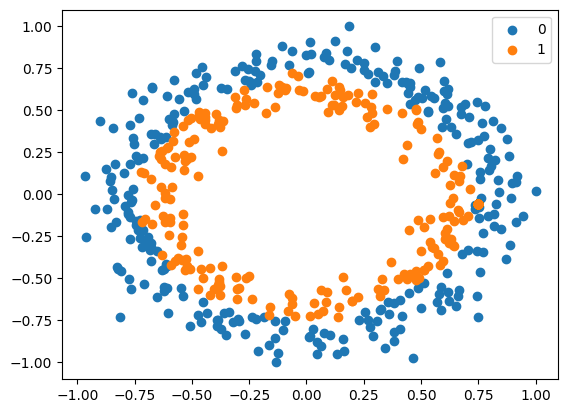

After 650 episodes:


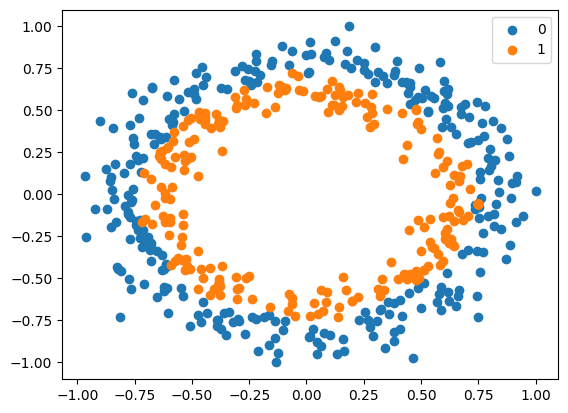

After 660 episodes:


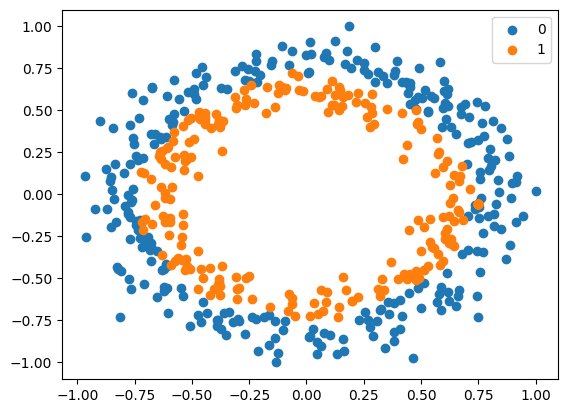

After 670 episodes:


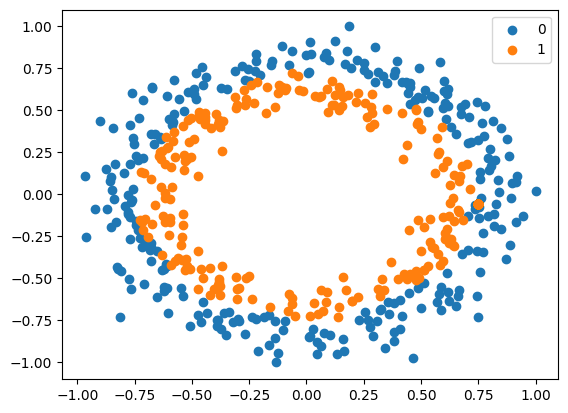

After 680 episodes:


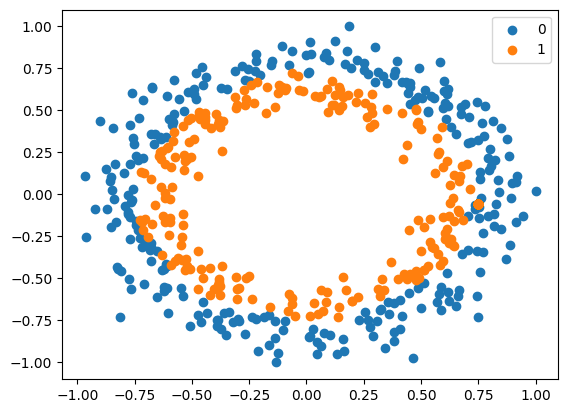

After 690 episodes:


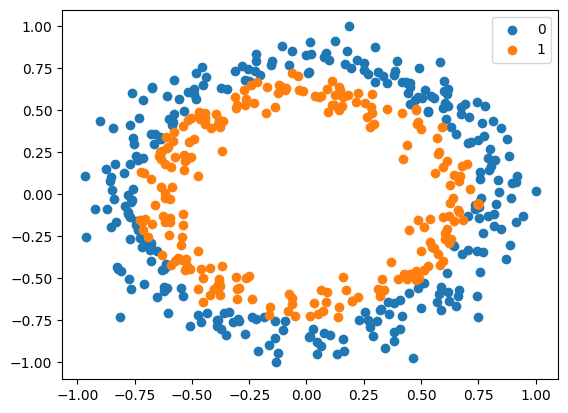

After 700 episodes:


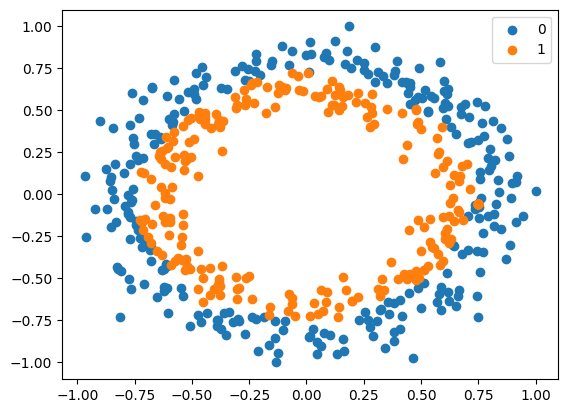

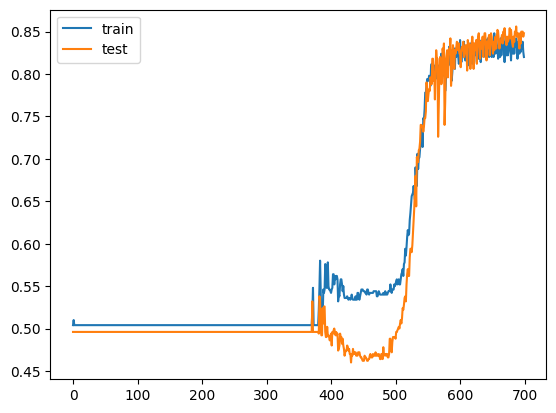

Evaluation
16/16 [==============================] - 0s 1ms/step - loss: 0.3634 - accuracy: 0.8480


In [36]:
tf.random.set_seed(42)

init = tf.keras.initializers.GlorotNormal()

inputs = tf.keras.Input(shape=(2,), name="input_values")
h = tf.keras.layers.Dense(5, activation="relu", kernel_initializer=init)(inputs)
h = tf.keras.layers.Dense(5, activation="relu", kernel_initializer=init)(h)
h = tf.keras.layers.Dense(5, activation="relu", kernel_initializer=init)(h)
h = tf.keras.layers.Dense(5, activation="relu", kernel_initializer=init)(h)
h = tf.keras.layers.Dense(5, activation="relu", kernel_initializer=init)(h)
h = tf.keras.layers.Dense(5, activation="relu", kernel_initializer=init)(h)
h = tf.keras.layers.Dense(5, activation="relu", kernel_initializer=init)(h)
outputs = tf.keras.layers.Dense(1)(h)
outputs = tf.keras.activations.sigmoid(outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

run(model, 70)

### Models with tanh

In [ ]:
tf.random.set_seed(42)

init = tf.keras.initializers.GlorotNormal()

inputs = tf.keras.Input(shape=(2,), name="input_values")
h = tf.keras.layers.Dense(2, activation="tanh", kernel_initializer=init)(inputs)
outputs = tf.keras.layers.Dense(1)(h)
outputs = tf.keras.activations.sigmoid(outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

run(model, 20)

In [ ]:
tf.random.set_seed(42)

init = tf.keras.initializers.GlorotNormal()

inputs = tf.keras.Input(shape=(2,), name="input_values")
h = tf.keras.layers.Dense(10, activation="tanh", kernel_initializer=init)(inputs)
outputs = tf.keras.layers.Dense(1)(h)
outputs = tf.keras.activations.sigmoid(outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

run(model, 20)

In [ ]:
tf.random.set_seed(42)

init = tf.keras.initializers.GlorotNormal()

inputs = tf.keras.Input(shape=(2,), name="input_values")
h = tf.keras.layers.Dense(5, activation="tanh", kernel_initializer=init)(inputs)
h = tf.keras.layers.Dense(5, activation="tanh", kernel_initializer=init)(h)
h = tf.keras.layers.Dense(5, activation="tanh", kernel_initializer=init)(h)
outputs = tf.keras.layers.Dense(1)(h)
outputs = tf.keras.activations.sigmoid(outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

run(model, 20)

In [ ]:
tf.random.set_seed(42)

init = tf.keras.initializers.RandomUniform(minval=0, maxval=1)

inputs = tf.keras.Input(shape=(2,), name="input_values")
h = tf.keras.layers.Dense(5, activation="tanh", kernel_initializer=init)(inputs)
h = tf.keras.layers.Dense(5, activation="tanh", kernel_initializer=init)(h)
h = tf.keras.layers.Dense(5, activation="tanh", kernel_initializer=init)(h)
h = tf.keras.layers.Dense(5, activation="tanh", kernel_initializer=init)(h)
h = tf.keras.layers.Dense(5, activation="tanh", kernel_initializer=init)(h)
h = tf.keras.layers.Dense(5, activation="tanh", kernel_initializer=init)(h)
outputs = tf.keras.layers.Dense(1)(h)
outputs = tf.keras.activations.sigmoid(outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

run(model, 20)

In [ ]:
model.layers

In [ ]:
# Check the gradients
with tf.GradientTape() as tape:
    prediction = model(trainX, training=True)
    loss_value = loss_fn(testy, prediction)

grads = tape.gradient(loss_value, model.trainable_weights)

print("\n>>> GRADIENTS:")

for i in range(len(model.layers)):
    l = int((i + 1) / 2)
    print('-' * 100)
    print("# {} layer weights \n{} \n".format(l, grads[i].numpy()))
    print("# {} layer bias \n{} \n".format(l, grads[i+1].numpy()))

### Models without activations

In [ ]:
init = tf.keras.initializers.RandomUniform(minval=0, maxval=1)
init = tf.keras.initializers.GlorotNormal()

inputs = tf.keras.Input(shape=(2,), name="input_values")
h = tf.keras.layers.Dense(5, activation=None, kernel_initializer=init)(inputs)
h = tf.keras.layers.Dense(5, activation=None, kernel_initializer=init)(h)
h = tf.keras.layers.Dense(5, activation=None, kernel_initializer=init)(h)
h = tf.keras.layers.Dense(5, activation=None, kernel_initializer=init)(h)
h = tf.keras.layers.Dense(5, activation=None, kernel_initializer=init)(h)
outputs = tf.keras.layers.Dense(1)(h)
outputs = tf.keras.activations.sigmoid(outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

run(model, 20)

<span style="color:red">**TO DO:** Similar to the accuracy, store and plot also the train and test loss. Inspect the loss evolution.</span>

### Multiclass classification

In [ ]:
from sklearn.datasets import make_classification

In [ ]:
# generate 2d classification dataset
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, 
                           n_redundant=0, n_classes=4, random_state=1, n_clusters_per_class=1,
                           class_sep=2)
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)
# split into train and test
n_train = 500

trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

for i in range(4):
    samples_ix = np.where(y == i)
    pyplot.scatter(X[samples_ix, 0], X[samples_ix, 1], label=str(i))
pyplot.legend()
pyplot.show()

#### ReLU models

In [ ]:
# Define model run for various model specifications
def run(model):
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

    model.compile(loss=loss_fn, optimizer=optimizer, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

    acc_train = []
    acc_test = []
    for r in range(20):
        print("After {} episodes:".format((r + 1)* 10))
        history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=10, verbose=0)
        acc_train.extend(history.history['sparse_categorical_accuracy'])
        acc_test.extend(history.history['val_sparse_categorical_accuracy'])

        prediction = model.predict(trainX)
        prediction = np.argmax(model.predict(trainX), axis=1)

        for i in range(4):
            samples_ix = np.where(prediction == i)
            pyplot.scatter(X[samples_ix, 0], X[samples_ix, 1], label=str(i))
        pyplot.legend()
        pyplot.show()

    pyplot.plot(acc_train, label='train')
    pyplot.plot(acc_test, label='test')
    pyplot.legend()
    pyplot.show()

    print('Evaluation')
    model.evaluate(testX, testy)

In [ ]:
tf.random.set_seed(42)

init = tf.keras.initializers.RandomUniform(minval=0, maxval=1)

inputs = tf.keras.Input(shape=(2,), name="input_values")
h = tf.keras.layers.Dense(5, activation="relu", kernel_initializer=init)(inputs)
outputs = tf.keras.layers.Dense(4)(h)
outputs = tf.keras.activations.softmax(outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

run(model)

In [ ]:
tf.random.set_seed(42)

init = tf.keras.initializers.GlorotNormal()

inputs = tf.keras.Input(shape=(2,), name="input_values")
h = tf.keras.layers.Dense(10, activation="relu", kernel_initializer=init)(inputs)
h = tf.keras.layers.Dense(10, activation="relu", kernel_initializer=init)(h)
h = tf.keras.layers.Dense(10, activation="relu", kernel_initializer=init)(h)
outputs = tf.keras.layers.Dense(4)(h)
outputs = tf.keras.activations.softmax(outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

run(model)

In [ ]:
tf.random.set_seed(42)

init = tf.keras.initializers.RandomUniform(minval=0, maxval=1)

inputs = tf.keras.Input(shape=(2,), name="input_values")
h = tf.keras.layers.Dense(5, activation="relu", kernel_initializer=init)(inputs)
h = tf.keras.layers.Dense(5, activation="relu", kernel_initializer=init)(h)
h = tf.keras.layers.Dense(5, activation="relu", kernel_initializer=init)(h)
outputs = tf.keras.layers.Dense(4)(h)
outputs = tf.keras.activations.softmax(outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

run(model)

### Complex multiclass

In [ ]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [ ]:
# Define model run for various model specifications
def run(model):
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

    model.compile(loss=loss_fn, optimizer=optimizer, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

    acc_train = []
    acc_test = []
    for r in range(20):
        print("After {} episodes:".format((r + 1)* 10))
        history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=10, verbose=0)
        acc_train.extend(history.history['sparse_categorical_accuracy'])
        acc_test.extend(history.history['val_sparse_categorical_accuracy'])

        prediction = model.predict(trainX)
        prediction = np.argmax(model.predict(trainX), axis=1)

        for i in range(4):
            samples_ix = np.where(prediction == i)
            pyplot.scatter(trainX[samples_ix, 0], trainX[samples_ix, 1], label=str(i))
        pyplot.legend()
        pyplot.show()

    pyplot.plot(acc_train, label='train')
    pyplot.plot(acc_test, label='test')
    pyplot.legend()
    pyplot.show()

    print('Evaluation')
    model.evaluate(testX, testy)

In [ ]:
# generate 2d classification dataset
X_1, y_1 = make_moons(n_samples=1000, random_state=42, noise=0.2)
scaler = MinMaxScaler(feature_range=(-1, 1))
X_1 = scaler.fit_transform(X_1)

X_2, y_2 = make_moons(n_samples=1000, random_state=42, noise=0.2)
scaler = MinMaxScaler(feature_range=(-1, 1))
X_2 = scaler.fit_transform(X_1)

X = np.append(X_1, X_2 * np.array([1.2, 0.8]) + np.array([-1, -1]), axis=0)
y = np.append(y_1, y_2 + 2, axis=0)

trainX, testX, trainy, testy = train_test_split(X, y, random_state=3)

for i in range(4):
    samples_ix = np.where(y == i)
    pyplot.scatter(X[samples_ix, 0], X[samples_ix, 1], label=str(i))
pyplot.legend()
pyplot.show()

#### Model with ReLU

In [ ]:
tf.random.set_seed(42)

init = tf.keras.initializers.RandomUniform(minval=0, maxval=1)

inputs = tf.keras.Input(shape=(2,), name="input_values")
h = tf.keras.layers.Dense(5, activation="relu", kernel_initializer=init)(inputs)

outputs = tf.keras.layers.Dense(4)(h)
outputs = tf.keras.activations.softmax(outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

run(model)

In [ ]:
tf.random.set_seed(42)

init = tf.keras.initializers.RandomUniform(minval=0, maxval=1)

inputs = tf.keras.Input(shape=(2,), name="input_values")
h = tf.keras.layers.Dense(100, activation="relu", kernel_initializer=init)(inputs)

outputs = tf.keras.layers.Dense(4)(h)
outputs = tf.keras.activations.softmax(outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

run(model)

In [ ]:
tf.random.set_seed(42)

init = tf.keras.initializers.RandomUniform(minval=0, maxval=1)

inputs = tf.keras.Input(shape=(2,), name="input_values")
h = tf.keras.layers.Dense(50, activation="relu", kernel_initializer=init)(inputs)
h = tf.keras.layers.Dense(50, activation="relu", kernel_initializer=init)(inputs)
h = tf.keras.layers.Dense(50, activation="relu", kernel_initializer=init)(inputs)

outputs = tf.keras.layers.Dense(4)(h)
outputs = tf.keras.activations.softmax(outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

run(model)

In [ ]:
# def run(model, iterations):
#     optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
#     loss_fn = tf.keras.losses.BinaryCrossentropy()

#     model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#     acc_train = []
#     acc_test = []
#     loss_train = []
#     loss_test = []

#     for r in range(iterations):
#         print("After {} episodes:".format((r + 1) * 10))
#         history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=10, batch_size=100, verbose=0)
#         acc_train.extend(history.history['accuracy'])
#         acc_test.extend(history.history['val_accuracy'])
#         loss_train.extend(history.history['loss'])
#         loss_test.extend(history.history['val_loss'])

#         prediction = model.predict(trainX)
#         prediction = np.where(model.predict(trainX) > 0.5, 1, 0)

#         for i in range(2):
#             samples_ix = np.where(prediction == i)
#             pyplot.scatter(X[samples_ix, 0], X[samples_ix, 1], label=str(i))
#         pyplot.legend()
#         pyplot.show()

#     pyplot.plot(acc_train, label='train')
#     pyplot.plot(acc_test, label='test')
#     pyplot.legend()
#     pyplot.show()

#     pyplot.plot(loss_train, label='train')
#     pyplot.plot(loss_test, label='test')
#     pyplot.legend()
#     pyplot.show()

#     print('Evaluation')
#     model.evaluate(testX, testy)